## Image Recognition with Custom WideResNet: Concat Pooling

#### Imports due to working within colab 

In [0]:
import shutil
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Required imports for project

Although 'from module import *'  is not preferable way of importing additional functionality, fastai was designed the way to be used this way and it is encouraged by Jeremy Howard to do so.

In [0]:
import os
import zipfile
import tarfile
import pandas as pd
import fastai ## only to print version
from fastai import * 
from fastai.vision import * 
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [0]:
print("pandas",pd.__version__)
print("numpy", np.__version__)
print("matplotlib",matplotlib.__version__)
print("torch",torch.__version__)
print("fastai",fastai.__version__)

pandas 0.24.2
numpy 1.16.4
matplotlib 3.0.3
torch 1.1.0
fastai 1.0.53.post2


#### Downloading dataset directly from kaggle  

In order to download data directly to kaggle, one needs to generate kaggle.json for account.  
I have uploaded mine into my google drive from where I am copying it to colab space.

In [0]:
shutil.copy2('/content/gdrive/My Drive/kaggle.json','/content/')

'/content/kaggle.json'

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
os.listdir()

100% 297M/298M [00:08<00:00, 42.8MB/s]
100% 298M/298M [00:08<00:00, 38.1MB/s]


['.config',
 'gtsrb-german-traffic-sign.zip',
 'gdrive',
 'kaggle.json',
 'sample_data']

#### Loading dataset

In [0]:
os.mkdir("GTSRB")
!mv gtsrb-german-traffic-sign.zip GTSRB/
os.chdir("GTSRB")


In [0]:
with zipfile.ZipFile("gtsrb-german-traffic-sign.zip","r") as file:
    file.extractall()
os.listdir()

['Train.tar',
 'Meta.tar',
 'gtsrb-german-traffic-sign.zip',
 'Train.csv',
 'Test.csv',
 'Meta.csv',
 'Test.tar']

In [0]:
os.mkdir("Test")
os.mkdir("Train")
with tarfile.open("Test.tar") as file:
  file.extractall("Test")
with tarfile.open("Train.tar") as file:
  file.extractall("Train")

In [0]:
test_df = pd.read_csv("Test.csv")
train_df = pd.read_csv("Train.csv")
combined_df = train_df.append(test_df)[["Path","ClassId"]]
combined_df.reset_index(inplace=True, drop= True)

In [0]:
data = ImageDataBunch.from_df("", combined_df, ds_tfms=get_transforms(do_flip=False), size = 32, bs = 384 )
data = data.normalize()
data

ImageDataBunch;

Train: LabelList (41472 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
20,20,20,20,20
Path: .;

Valid: LabelList (10367 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
4,33,18,10,33
Path: .;

Test: None

#### Creating & running a model with FastAI WRN API

In [0]:
arch = models.WideResNet(
    num_groups=3,
    N=2,
    num_classes=len(data.classes),
    k=4,
    drop_p=0.2)
learn = Learner(data, arch.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn.to_fp16()
learn.summary()

WideResNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 32]         432        True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
Conv2d               [64, 32, 32]         9,216      True      
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     True      
______________________________________________________________________
Dropout              [64, 32, 32]         0          False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


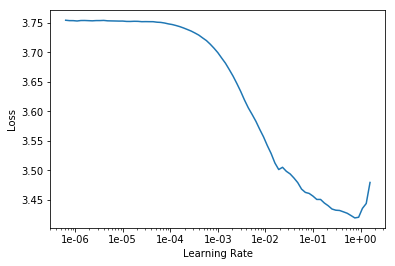

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, max_lr=1e-02,wd=0.1)

#### Summary

After running for 15 epochs we receive already quite nice accuracy with German Traffic Signs Recognition Benchmark Dataset.  
However in my opinion WRN API could receive some further tuning.  

First what might be noticed drop probability is implemented as constant over whole network.  
Personally I like to think of dropout as taxes.   
Probably in many countries percent of taxes differs depending on overall income.  
Looking at this analogy let's implement choice for different dropout probability for each of WRN groups.    

Staying in dropout topic, we can also notice lack of implementation in the output layer, let's add it.  

Within whole architecture as activation is implemented ReLU, which is as of current the most popular activation function. 
But with emerge of Swish which for some od datasets performs slight better it would be nice to give a chance for choice. Looking more into future we will implement not a choice between ReLU or Swish but possibility to declare any activation layer.

On the fastai site: https://docs.fast.ai/layers.html idea of concatenating max pooling and average pooling is introduced as AdaptiveConcatPool2d layer. It performs better than both AdaptiveAvgPool2d and AdaptiveMaxPool2d, so we will change output maxpool for concatpool.

Last but not least, if concat pooling performs noticeably better than avg and max for last layer, why not to try implement the very same idea over whole architecture instead of stride, which is basically maxpool.


## Concat Pool over whole network test

Before we recreate WRN API let's first test if implementing ConcatPool gives and additional benefits compared to MaxPool.  
We will define two simple models and validate over MNIST_SAMPLE

In [0]:
class ConcatPool2d(nn.Module):
  "Layer that concats `AvgPool2d` and `MaxPool2d`"
 
  def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.pool_size = sz or 1
        self.ap = nn.AvgPool2d(self.pool_size)
        self.mp = nn.MaxPool2d(self.pool_size)

  def forward(self, x):
    return torch.cat([self.mp(x), self.ap(x)], 1)


In [0]:

ni=3
nf=16
ne = 2

def ccp_seq(ni,nf):
    return nn.Sequential(
            nn.Conv2d(ni,nf,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(nf),
            ConcatPool2d(2)
            )
        
def maxp_seq(ni,nf):
    return nn.Sequential(
            nn.Conv2d(ni,nf,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(nf),
            nn.MaxPool2d(2)
            )

concat_model = nn.Sequential(
    ccp_seq(ni,nf),
    ccp_seq(2*nf,nf),
    nn.Sequential(
        nn.Conv2d(2*nf,ne,3,padding=1),
        nn.ReLU(),
        AdaptiveConcatPool2d(1),
        Flatten()
        )
    )

max_model = nn.Sequential(
    maxp_seq(ni,nf),
    maxp_seq(nf,nf),
    nn.Sequential(
        nn.Conv2d(nf,ne,3,padding=1),
        nn.ReLU(),
        AdaptiveConcatPool2d(1),
        Flatten()
        )
    )

In [0]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

simple_max = Learner(data, max_model, metrics=[accuracy])
simple_concat = Learner(data, concat_model, metrics=[accuracy])


print(simple_max.summary())
print()
print()
print(simple_concat.summary())


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 28, 28]         448        True      
______________________________________________________________________
ReLU                 [16, 28, 28]         0          False     
______________________________________________________________________
BatchNorm2d          [16, 28, 28]         32         True      
______________________________________________________________________
MaxPool2d            [16, 14, 14]         0          False     
______________________________________________________________________
Conv2d               [16, 14, 14]         2,320      True      
______________________________________________________________________
ReLU                 [16, 14, 14]         0          False     
______________________________________________________________________
BatchNorm2d          [16, 14, 14]         32         True      
___________________________________________________

In [0]:
simple_max.fit_one_cycle(5,max_lr=1e-03,wd=0.1)

In [0]:
simple_concat.fit_one_cycle(5,max_lr=1e-03,wd=0.1)

There is some value added from concat pool, let's add it to our custom WRN API.

## WideResNet fastai API

In [0]:
def _bn(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm2d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv2d(ni, nf, ks, stride))

class BasicBlock(Module):
    "Block to from a wide ResNet."
    def __init__(self, ni, nf, stride, drop_p=0.0):
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv2d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv2d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

class WideResNet(Module):
    "Wide ResNet with `num_groups` and a width of `k`."
    def __init__(self, num_groups:int, N:int, num_classes:int, k:int=1, drop_p:float=0.0, start_nf:int=16, n_in_channels:int=3):
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)

        layers = [conv2d(n_in_channels, n_channels[0], 3, 1)]  # conv1
        for i in range(num_groups):
            layers += _make_group(N, n_channels[i], n_channels[i+1], BasicBlock, (1 if i==0 else 2), drop_p)

        layers += [nn.BatchNorm2d(n_channels[num_groups]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
                   Flatten(), nn.Linear(n_channels[num_groups], num_classes)]
        self.features = nn.Sequential(*layers)

    def forward(self, x): return self.features(x)


## ConcatPool WideResNet API

#### Changes to parameters:

_____________________ 
drop_p:list=[0.0]
drop_m:list = [1.]   

Drop probability and multiplication are related to each other.  
Both are given as list, this way we can define different values for each group.  
As with Concat Pooling we double the size of layer retrieving correlated information, drop multiplication gives a chance to increase drop probability even more for this sequence.  
Simple idea behind if that if we use 50% drop probability for max or avg pool we lose 50% information, but if we use 50% drop probability for concat pool in special circumstances we may still receive whole information of max or avg pool.    
Multiplication gives us also a possibility to mute drop for concat pool sequence.  
For both of parameters, if the user is willing to implement constant drop over whole network, API may take list of length 1. This way the same drop probability is set to each group.  
___________________________
drop_last_p:float = 0.0  

As the name suggest it sets dropout probability for output layer.
_________________________
activation=nn.ReLU  
activation_parameters:dict={}  

Our activation function is given as class after nn.Module and it's parameters are given separately.  
It has been implemented this way as giving activation layer together with parameters resulted in creating activation layers over whole network with number of neurons inherited form the last activation layer in architecture.
_________________________

In [0]:

class ConcatPool2d(nn.Module):
  "Layer that concats `AvgPool2d` and `MaxPool2d`"

  def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.output_size = sz or 1
        self.ap = nn.AvgPool2d(self.output_size)
        self.mp = nn.MaxPool2d(self.output_size)

  def forward(self, x): 
    return torch.cat([self.mp(x), self.ap(x)], 1)


def _bn(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm2d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_activation_conv(ni, nf, ks, stride, activation,init_zero=False):
    bn_initzero = _bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, activation, conv2d(ni, nf, ks, stride))

class BasicBlock(nn.Module):
    "Block to from a wide ResNet."
    def __init__(self, ni, nf, stride, activation, drop_p):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.activation = activation
        self.conv1 = conv2d(ni, nf, 3, stride)
        self.conv2 = bn_activation_conv(nf, nf, 3, 1, activation)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv2d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = self.activation(self.bn(x))
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

def _make_group(N, ni, nf, block, stride,activation, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1,activation, drop_p) for i in range(N)]

class ConcatBlock(nn.Module):

    def __init__(self, ni, nf, stride, activation, drop_p,drop_m):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.activation = activation
        self.conv1 = cp_sequence(ni, nf,3, stride, activation, drop_p,drop_m)
        self.conv2 = bn_activation_conv(2*nf, nf , 3, 1, activation)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None                             
        self.shortcut =  cp_sequence(ni, nf,1, stride, activation, drop_p,drop_m)
          
    def forward(self, x):
        x2 = self.activation(self.bn(x))
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return torch.cat((x,x),dim=1).add_(r) if r.size()[1]/x.size()[1] == 2. else x.add_(r)
      
def cp_sequence(ni, nf,ks, stride, activation, drop_p,drop_m):
    if drop_p == 0 or drop_m ==0:
      seq = nn.Sequential(conv2d(ni, nf, ks), activation, nn.BatchNorm2d(nf), ConcatPool2d(stride))
    else:
      seq = nn.Sequential(conv2d(ni, nf, ks), activation, nn.BatchNorm2d(nf), ConcatPool2d(stride), nn.Dropout(drop_p*drop_m, inplace=True))
    return seq
      
def _make_group_concat(N, ni, nf, block, stride,activation, drop_p,drop_m):
    return [block[0](ni, nf, stride ,activation, drop_p,drop_m) if i == 0 
            else
            block[1](nf*2 if i == 1 else nf, nf,  1,activation, drop_p)
            for i in range(N)]
  
def check_params(N,num_groups,drop_p,drop_m):
  if N ==1:
    raise ValueError(f"ConcatPool Api requires minimum value for N parameter set to 2.")
  if len(drop_p) == 1:
    drop_p *= num_groups
  if len(drop_p) != num_groups:
    raise ValueError(f"Lenght of drop_p: {len(drop_p)}, must be equal to num_groups: {num_groups}.")
  if len(drop_m) == 1:
    drop_m *= num_groups
  if len(drop_m) != num_groups:
    raise ValueError(f"Lenght of drop_m: {len(drop_m)}, must be equal to num_groups: {num_groups}.")
  return drop_p , drop_m

class WideResNet_Concat(nn.Module):
    "Wide ResNet with `num_groups` and a width of `k`."
    def __init__(self, num_groups:int, N:int, num_classes:int, k:int=1, drop_p:list=[0.0],drop_m:list = [1.] , drop_last_p:float = 0.0
                 , start_nf:int=16, n_in_channels:int=3, activation=nn.ReLU, activation_parameters:dict={} ):
        super().__init__()
        
        drop_p , drop_m = check_params(N,num_groups,drop_p , drop_m)
        
        
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)

        layers = [conv2d(n_in_channels, n_channels[0], 3, 1)]

        
        for i in range(num_groups):
          if i == 0:
            layers += _make_group(N, n_channels[i], n_channels[i+1], BasicBlock, 1 ,
                                  activation(**activation_parameters), drop_p[i])            
          else:
            layers += _make_group_concat(N, n_channels[i], n_channels[i+1], [ConcatBlock,BasicBlock],2,
                                  activation(**activation_parameters), drop_p[i], drop_m[i])

        if drop_last_p == 0:
          layers += [nn.BatchNorm2d(n_channels[num_groups]), 
                   activation(**activation_parameters),
                   AdaptiveConcatPool2d(1),
                   Flatten(), nn.Linear(2*n_channels[num_groups], num_classes)]
        else:
          layers += [nn.BatchNorm2d(n_channels[num_groups]), 
                   activation(**activation_parameters),
                   AdaptiveConcatPool2d(1),
                   nn.Dropout(drop_last_p, inplace=True),
                   Flatten(), nn.Linear(2*n_channels[num_groups], num_classes)]

        self.features = nn.Sequential(*layers)

    def forward(self, x): return self.features(x)

## Concat WRN with GTSRB 

For our comparison to be fair we will use not only the same parameters, but also number of epochs and learning rate.

In [0]:
arch = WideResNet_Concat(
    num_groups=3,
    N=2,
    num_classes=len(data.classes),
    k=4,
    drop_p=[0.2],
    drop_m=[0.],
    activation= nn.ReLU,
    activation_parameters={"inplace":False}
    )

In [0]:
learn = Learner(data, arch.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn.to_fp16()
learn.summary()

WideResNet_Concat
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 32]         432        True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         9,216      True      
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     True      
____________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


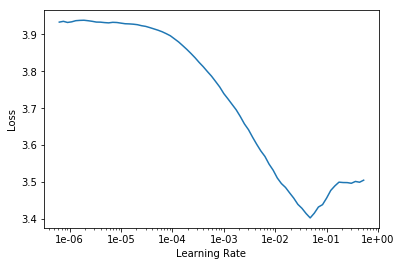

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, max_lr=1e-02,wd=0.1)

The results seems to be much better, Concat model achieves 90% accuracy in 2 epochs and 99% accuracy after 6 epochs.   
Standard WRN needed 4 epochs to break 90% and 9 epochs to achieve 99%.  
Additionally for standard WRN 99.97% was achieved only once, Concat achieves this result twice and even outperforms to 99,98% two times. 

## CIFAR10

ConcatPool WRN API seems to perform better, but as standard API already goes into less than 0.1% error, this test does not seem to squish max out of our API.  
Due to we will try again but with different dataset - CIFAR10, which is a collection of small pictures.  
Classifying CIFAR10 has same image recognition idea behind the scenes, but is much harder dataset. 

In [0]:
path = untar_data(URLs.CIFAR)
data = ImageList.from_folder(path)
data = data.split_by_folder(train='train', valid='test')
data = data.label_from_folder()


In [0]:
batch_size=256
data.transform(get_transforms(max_warp=0.3,max_lighting=0.65,p_lighting=0.9,max_rotate=25.,max_zoom=1.35))
data = data.databunch(bs=batch_size , num_workers=8).normalize()

Let's again create two models, one with fastai WRN API, other using our Concat WRN.  
For comparison to be fair we will use same parameters, number of epoch and learning rate.

In [0]:
arch_concat = WideResNet_Concat(
    num_groups=3,
    N=3,
    num_classes=len(data.classes),
    k=6,
    drop_p=[0.2],
    drop_m=[0.],
    activation= nn.ReLU
    ,activation_parameters={"inplace":False}
    )
arch_basic = models.WideResNet(
    num_groups=3,
    N=3, 
    num_classes=len(data.classes),
    k=6,
    drop_p=0.2)

learn_wrn_concat = Learner(data, arch_concat.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_basic = Learner(data, arch_basic.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat.to_fp16()
learn_wrn_basic.to_fp16()
print()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


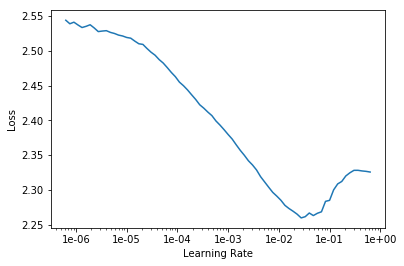

In [0]:
learn_wrn_concat.lr_find()
learn_wrn_concat.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


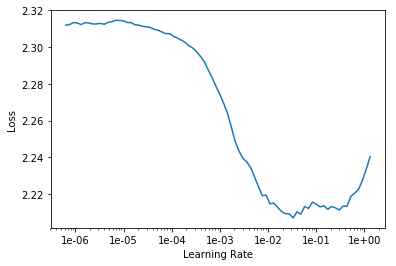

In [0]:
learn_wrn_basic.lr_find()
learn_wrn_basic.recorder.plot()

In [0]:
learn_wrn_basic.fit_one_cycle(100,max_lr=3e-03)

To extract valuable to us training data we will write function to do so.

In [0]:
def get_training_metrics(lrn):
  valid_loss = lrn.recorder.val_losses
  metric = [m[0].numpy() for m in lrn.recorder.metrics]
  train_loss = []
  ratio = len(lrn.data.train_ds) // lrn.data.batch_size
  for i in range(1,len(metric)+1):
    train_loss.append(lrn.recorder.losses[i*ratio-1].numpy())
  df = pd.DataFrame({"train_loss":train_loss,"valid_loss":valid_loss,"accuracy":metric})  
  df["train_valid_ratio"] = df["train_loss"] / df["valid_loss"]
  return df
  

In [0]:
df_wrn_basic = get_training_metrics(learn_wrn_basic)

In [0]:
df_wrn_basic.tail()

train_loss  valid_loss accuracy train_valid_ratio
95   0.05323948    0.211804   0.949          0.251362
96  0.050856583    0.211722  0.9497          0.240204
97  0.052444443    0.214227  0.9492          0.244808
98  0.052178293    0.213033  0.9487          0.244931
99  0.051589422    0.213636  0.9492          0.241483

In [0]:
learn_wrn_concat.fit_one_cycle(100,max_lr=3e-03)

Buffered data was truncated after reaching the output size limit.

### Comparison

In [0]:
df_wrn_concat = get_training_metrics(learn_wrn_concat)

In [0]:
df_wrn_compare = df_wrn_basic.join(df_wrn_concat,lsuffix="_basic",rsuffix="_concat")

In [0]:
df_wrn_compare.tail(60)

train_loss_basic  valid_loss_basic  ... accuracy_concat train_valid_ratio_concat
40        0.2812752          0.385612  ...         0.9274                  1.00001
41       0.26389366          0.330750  ...         0.9239                 0.874924
42       0.26265344          0.287009  ...          0.925                 0.907945
43       0.25564483          0.309016  ...         0.9304                 0.872158
44         0.248327          0.272047  ...         0.9332                 0.898676
45       0.24100766          0.275102  ...         0.9271                 0.772235
46        0.2383066          0.243725  ...         0.9302                 0.845448
47       0.22346072          0.284116  ...         0.9279                 0.766569
48       0.22288726          0.285854  ...         0.9375                 0.788445
49       0.21881014          0.256431  ...         0.9298                 0.749064
50       0.20653455          0.263183  ...         0.9319                  0.70643
51       0.20576017          0.266770  ...         0.9308                 0.645698
52       0.19720963          0.278478  ...         0.9308                 0.652671
53       0.18835367          0.232088  ...         0.9358                 0.698795
54       0.18697967          0.243944  ...         0.9347                 0.624038
55       0.18335679          0.226407  ...         0.9422                 0.714437
56       0.17601587          0.262427  ...         0.9381                 0.593334
57       0.16697332          0.233777  ...         0.9374                 0.594757
58       0.16940205          0.245191  ...         0.9426                 0.640998
59       0.16339508          0.243860  ...         0.9391                  0.55758
60       0.15925166          0.203558  ...         0.9463                 0.617431
61       0.14743699          0.215409  ...          0.944                  0.58569
62       0.14841603          0.228796  ...         0.9426                 0.518687
63       0.14253876          0.229052  ...         0.9446                 0.498688
64        0.1314798          0.229167  ...         0.9457                 0.464767
65       0.12996757          0.234949  ...         0.9453                 0.471258
66       0.12617584          0.235163  ...         0.9456                 0.478134
67       0.11792402          0.227151  ...         0.9472                 0.464577
68       0.11364528          0.236876  ...          0.946                 0.405898
69       0.11067165          0.219574  ...         0.9479                 0.425472
70        0.1084583          0.225014  ...         0.9495                 0.398203
71       0.10652212          0.220798  ...         0.9493                 0.399733
72      0.100197755          0.213875  ...         0.9528                 0.398708
73      0.098535486          0.229962  ...         0.9499                 0.340924
74       0.09416849          0.207694  ...         0.9515                 0.341532
75       0.09000235          0.222343  ...         0.9522                 0.335641
76       0.08394933          0.214771  ...          0.954                 0.339414
77       0.08422251          0.214948  ...          0.952                 0.321787
78       0.07665354          0.221072  ...         0.9536                  0.30125
79      0.079831585          0.213751  ...         0.9509                 0.271725
80       0.07526831          0.221151  ...         0.9519                  0.27557
81       0.06631546          0.217840  ...         0.9523                 0.255212
82       0.06712235          0.215188  ...         0.9517                 0.233898
83       0.06257239          0.220409  ...         0.9537                  0.25324
84      0.062281597          0.220919  ...         0.9539                 0.218667
85       0.06290093          0.217076  ...         0.9534                 0.221738
86      0.060738236          0.211854  ...         0.9534                 0.200453
87      0.05792657

Let's plot the data.

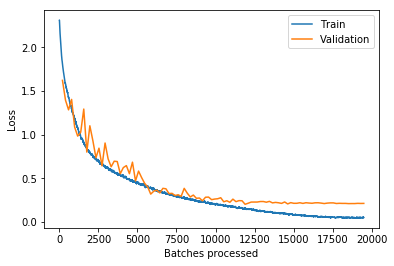

In [0]:
learn_wrn_basic.recorder.plot_losses()

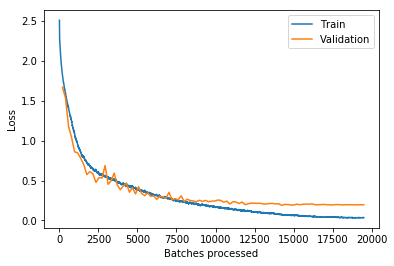

In [0]:
learn_wrn_concat.recorder.plot_losses()

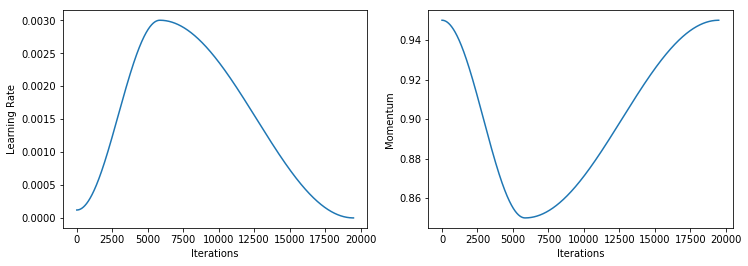

In [0]:
learn_wrn_basic.recorder.plot_lr(show_moms=True)

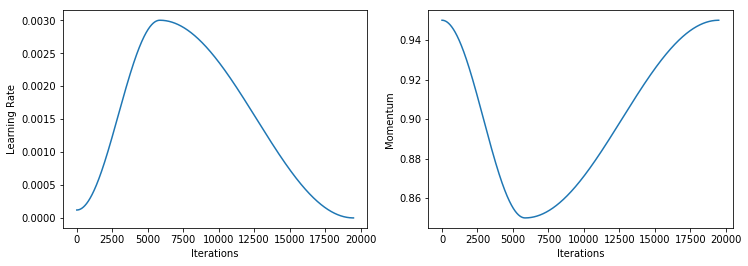

In [0]:
learn_wrn_concat.recorder.plot_lr(show_moms=True)

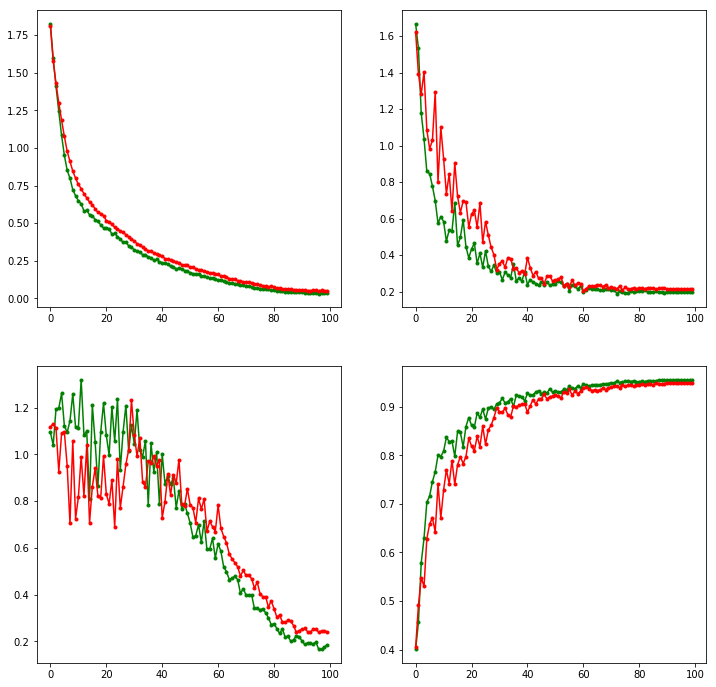

In [0]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

axs[0,0].plot(df_wrn_compare["train_loss_concat"], color='green', marker='.')
axs[0,0].plot(df_wrn_compare["train_loss_basic"], color='red', marker='.')

axs[0,1].plot(df_wrn_compare["valid_loss_concat"], color='green', marker='.')
axs[0,1].plot(df_wrn_compare["valid_loss_basic"], color='red', marker='.')

axs[1,0].plot(df_wrn_compare["train_valid_ratio_concat"], color='green', marker='.')
axs[1,0].plot(df_wrn_compare["train_valid_ratio_basic"], color='red', marker='.')

axs[1,1].plot(df_wrn_compare["accuracy_concat"], color='green', marker='.')
axs[1,1].plot(df_wrn_compare["accuracy_basic"], color='red', marker='.')
plt.show()

We will zoom in.

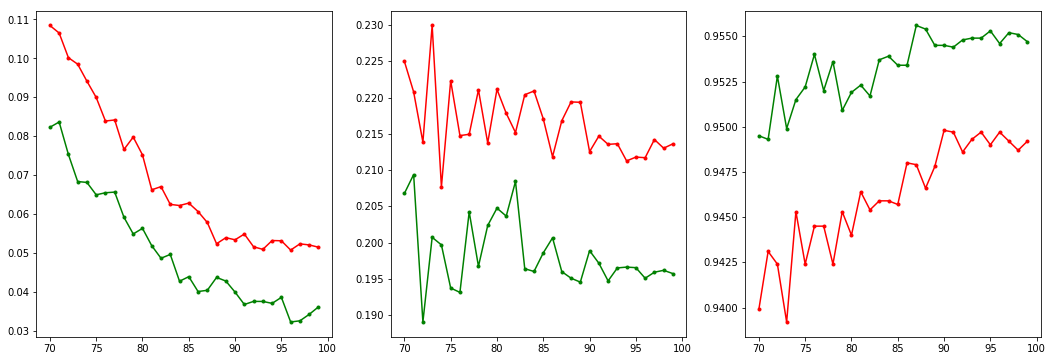

In [0]:
fig, axs = plt.subplots(1,3, figsize=(18,6))
m = 30
axs[0].plot(df_wrn_compare["train_loss_concat"].tail(m), color='green', marker='.')
axs[0].plot(df_wrn_compare["train_loss_basic"].tail(m), color='red', marker='.')

axs[1].plot(df_wrn_compare["valid_loss_concat"].tail(m), color='green', marker='.')
axs[1].plot(df_wrn_compare["valid_loss_basic"].tail(m), color='red', marker='.')

axs[2].plot(df_wrn_compare["accuracy_concat"].tail(m), color='green', marker='.')
axs[2].plot(df_wrn_compare["accuracy_basic"].tail(m), color='red', marker='.')
plt.show()

In [0]:
best_basic = (max(df_wrn_compare["accuracy_basic"]))
best_concat = (max(df_wrn_compare["accuracy_concat"]))
print("Max accuracy with basic WRN model")
print(best_basic)
print()
print("Max accuracy with concat WRN model")
print(best_concat)

Max accuracy with basic WRN model
0.9498

Max accuracy with concat WRN model
0.9556


As we can see our short test for implementation of concat pooling, gives better result that standard approach.  
We are fighting for last percents and each improvement which does not seems to be sheer luck or random initialization matters.   
Additionally we need to remember Cifar10 still stays quite difficult dataset thought being very classic in image recognition idea.  

### Maxing Cifar10
Let's try to max out our results with this approach.  
We will create 5 different architectures varying in depth, number of groups and number of neurons in layers, achieving each around 55 million parameters.  
We will try to set identical parameters for each of models, that means dropout, learning rate, number of epochs and even activation function.  
Additionally each model will be casted into fp16 precision to cut in half time required for our learning process. We will use fp32 only for tuning up our final model.

#### Models

In [0]:
arch_concat_4_wider = WideResNet_Concat(
    num_groups=4,
    N=2,
    num_classes=len(data.classes),
    k=7,
    drop_p=[.1,.2,.3,.4],
    drop_m=[1.5],
    drop_last_p =.65,
    activation= nn.ReLU
    ,activation_parameters={"inplace":False}
    )

learn_wrn_concat_4_wider = Learner(data, arch_concat_4_wider.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_wider.to_fp16()
learn_wrn_concat_4_wider.summary()


WideResNet_Concat
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 32]         432        True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
ReLU                 [112, 32, 32]        0          False     
______________________________________________________________________
Conv2d               [112, 32, 32]        16,128     True      
______________________________________________________________________
BatchNorm2d          [112, 32, 32]        224        True      
______________________________________________________________________
ReLU                 [112, 32, 32]        0          False     
______________________________________________________________________
Conv2d               [112, 32, 32]        112,896    True      
____________________________________________

In [0]:
arch_concat_4_base = WideResNet_Concat(
    num_groups=4,
    N=3,
    num_classes=len(data.classes),
    k=6,
    drop_p=[.1,.2,.3,.4],
    drop_m=[1.5],
    drop_last_p =.65,
    activation= nn.ReLU
    ,activation_parameters={"inplace":False}
    )

learn_wrn_concat_4_base = Learner(data, arch_concat_4_base.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_base.to_fp16()
learn_wrn_concat_4_base.summary()


WideResNet_Concat
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 32]         432        True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
ReLU                 [96, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [96, 32, 32]         13,824     True      
______________________________________________________________________
BatchNorm2d          [96, 32, 32]         192        True      
______________________________________________________________________
ReLU                 [96, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [96, 32, 32]         82,944     True      
____________________________________________

In [0]:
arch_concat_3_widest = WideResNet_Concat(
    num_groups=3,
    N=2,
    num_classes=len(data.classes),
    k=14,
    drop_p=[.2,.3,.4],
    drop_m=[1.5],
    drop_last_p =.65,
    activation= nn.ReLU
    ,activation_parameters={"inplace":False}
    )

learn_wrn_concat_3_widest = Learner(data, arch_concat_3_widest.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_3_widest.to_fp16()
learn_wrn_concat_3_widest.summary()


WideResNet_Concat
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 32]         432        True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
ReLU                 [224, 32, 32]        0          False     
______________________________________________________________________
Conv2d               [224, 32, 32]        32,256     True      
______________________________________________________________________
BatchNorm2d          [224, 32, 32]        448        True      
______________________________________________________________________
ReLU                 [224, 32, 32]        0          False     
______________________________________________________________________
Conv2d               [224, 32, 32]        451,584    True      
____________________________________________

In [0]:
arch_concat_3_wider = WideResNet_Concat(
    num_groups=3,
    N=4,
    num_classes=len(data.classes),
    k=11,
    drop_p=[.2,.3,.4],
    drop_m=[1.5],
    drop_last_p =.65,
    activation= nn.ReLU
    ,activation_parameters={"inplace":False}
    )

learn_wrn_concat_3_wider = Learner(data, arch_concat_3_wider.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_3_wider.to_fp16()
learn_wrn_concat_3_wider.summary()


WideResNet_Concat
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 32]         432        True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
ReLU                 [176, 32, 32]        0          False     
______________________________________________________________________
Conv2d               [176, 32, 32]        25,344     True      
______________________________________________________________________
BatchNorm2d          [176, 32, 32]        352        True      
______________________________________________________________________
ReLU                 [176, 32, 32]        0          False     
______________________________________________________________________
Conv2d               [176, 32, 32]        278,784    True      
____________________________________________

In [0]:
arch_concat_3_wide_deep = WideResNet_Concat(
    num_groups=3,
    N=5,
    num_classes=len(data.classes),
    k=10,
    drop_p=[.2,.3,.4],
    drop_m=[1.5],
    drop_last_p =.65,
    activation= nn.ReLU
    ,activation_parameters={"inplace":False}
    )

learn_wrn_concat_3_wide_deep = Learner(data, arch_concat_3_wide_deep.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_3_wide_deep.to_fp16()
learn_wrn_concat_3_wide_deep.summary()


WideResNet_Concat
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 32]         432        True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
ReLU                 [160, 32, 32]        0          False     
______________________________________________________________________
Conv2d               [160, 32, 32]        23,040     True      
______________________________________________________________________
BatchNorm2d          [160, 32, 32]        320        True      
______________________________________________________________________
ReLU                 [160, 32, 32]        0          False     
______________________________________________________________________
Conv2d               [160, 32, 32]        230,400    True      
____________________________________________

#### Lr find
We will check for suggestions for learning rates of each model, pick the smallest one and use it for each. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


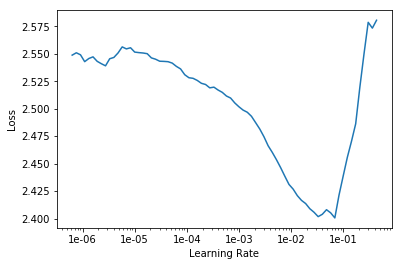

In [0]:
learn_wrn_concat_4_wider.lr_find()
learn_wrn_concat_4_wider.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


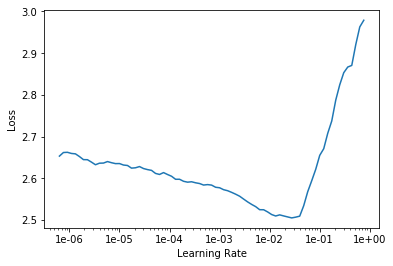

In [0]:
learn_wrn_concat_4_base.lr_find()
learn_wrn_concat_4_base.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


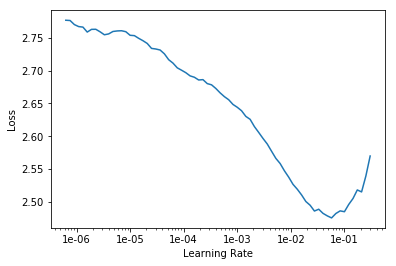

In [0]:
learn_wrn_concat_3_widest.lr_find()
learn_wrn_concat_3_widest.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


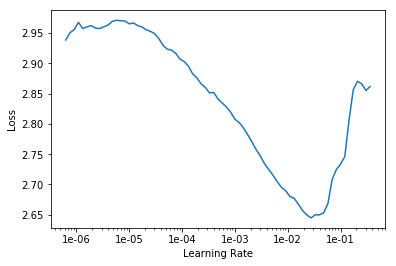

In [0]:
learn_wrn_concat_3_wider.lr_find()
learn_wrn_concat_3_wider.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


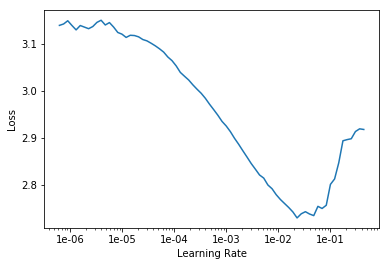

In [0]:
learn_wrn_concat_3_wide_deep.lr_find()
learn_wrn_concat_3_wide_deep.recorder.plot()

We will set maximum learning rate to 0.003 

#### Fitting

In [0]:
learn_wrn_concat_4_wider.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

In [0]:
df_wrn_concat_4_wider = get_training_metrics(learn_wrn_concat_4_wider)
df_wrn_concat_4_wider.to_csv('/content/df_wrn_concat_4_wider.csv',sep="|")
shutil.copy2('/content/df_wrn_concat_4_wider.csv','/content/gdrive/My Drive/df_wrn_concat_4_wider.csv')


'/content/gdrive/My Drive/df_wrn_concat_4_wider.csv'

In [0]:
learn_wrn_concat_4_base.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

In [0]:
df_wrn_concat_4_base = get_training_metrics(learn_wrn_concat_4_base)
df_wrn_concat_4_base.to_csv('/content/df_wrn_concat_4_base.csv',sep="|")
shutil.copy2('/content/df_wrn_concat_4_base.csv','/content/gdrive/My Drive/df_wrn_concat_4_base.csv')

'/content/gdrive/My Drive/df_wrn_concat_4_base.csv'

In [0]:
learn_wrn_concat_3_widest.fit_one_cycle(150,max_lr=3e-03,wd=0.1)


In [0]:
df_wrn_concat_3_widest = get_training_metrics(learn_wrn_concat_3_widest)
df_wrn_concat_3_widest.to_csv('/content/df_wrn_concat_3_widest.csv',sep="|")
shutil.copy2('/content/df_wrn_concat_3_widest.csv','/content/gdrive/My Drive/df_wrn_concat_3_widest.csv')

'/content/gdrive/My Drive/df_wrn_concat_3_widest.csv'

In [0]:
learn_wrn_concat_3_wider.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_3_wider = get_training_metrics(learn_wrn_concat_3_wider)
df_wrn_concat_3_wider.to_csv('/content/df_wrn_concat_3_wider.csv',sep="|")

## Issues with drive, uploaded manually 
from google.colab import files
files.download('/content/df_wrn_concat_3_wider.csv')

In [0]:
learn_wrn_concat_3_wide_deep.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_3_wide_deep = get_training_metrics(learn_wrn_concat_3_wide_deep)
df_wrn_concat_3_wide_deep.to_csv('/content/df_wrn_concat_3_wide_deep.csv',sep="|")
shutil.copy2('/content/df_wrn_concat_3_wide_deep.csv','/content/gdrive/My Drive/df_wrn_concat_3_wide_deep.csv')

'/content/gdrive/My Drive/df_wrn_concat_3_wide_deep.csv'

#### Comparison

As metrics for each model was saved to my personal google drive in .csv format, we will create another function to join them into one pandas dataframe.

In [0]:
def join_multi_csv(paths,suffixes,sep:str="|"):
    dfs = [pd.read_csv(path, sep=sep,index_col=[0],engine='c' ) for path in paths]
    
    out = dfs[0]
    i=0
    for df in dfs[1:]:
        i+=1 
        if i<len(paths)-1:
            out = out.join(df,lsuffix="",rsuffix=suffixes[i])
        else:
            out = out.join(df,lsuffix=suffixes[0],rsuffix=suffixes[i])
    return out




In [0]:
paths = [
    'df_wrn_concat_3_widest.csv',
    'df_wrn_concat_3_wider.csv',
    'df_wrn_concat_3_wide_deep.csv',
    'df_wrn_concat_4_wider.csv',
    'df_wrn_concat_4_base.csv'
]
suffixes = [
    '_3_widest',
    '_3_wider',
    '_3_wide_deep',
    '_4_wider',
    '_4_base'
]

In [0]:
os.chdir('/content/gdrive/My Drive/')
df_compare = join_multi_csv(paths,suffixes)

In [0]:
df_compare.tail(10).T

140       141  ...       148       149
train_loss_3_widest            0.054478  0.055659  ...  0.050927  0.051056
valid_loss_3_widest            0.170188  0.170045  ...  0.170895  0.168355
accuracy_3_widest               0.960100  0.959400  ...  0.960200  0.960200
train_valid_ratio_3_widest     0.320103  0.327318  ...  0.298001  0.303263
train_loss_3_wider             0.044617  0.042971  ...  0.037198  0.038319
valid_loss_3_wider             0.168607  0.172201  ...  0.171877  0.172645
accuracy_3_wider                0.964400  0.963900  ...  0.964000  0.963200
train_valid_ratio_3_wider      0.264619  0.249539  ...  0.216421  0.221952
train_loss_3_wide_deep         0.043749  0.047100  ...  0.039921  0.038834
valid_loss_3_wide_deep         0.165758  0.164124  ...  0.165975  0.164735
accuracy_3_wide_deep            0.962100  0.963300  ...  0.963700  0.964000
train_valid_ratio_3_wide_deep  0.263933  0.286976  ...  0.240526  0.235735
train_loss_4_wider             0.068096  0.063782  ...  0.059426  0.060880
valid_loss_4_wider             0.159306  0.159289  ...  0.158822  0.158438
accuracy_4_wider                0.959500  0.958600  ...  0.959500  0.958900
train_valid_ratio_4_wider      0.427455  0.400416  ...  0.374170  0.384253
train_loss_4_base              0.058487  0.055925  ...  0.055345  0.048660
valid_loss_4_base              0.161586  0.165116  ...  0.163904  0.164333
accuracy_4_base                 0.961200  0.960100  ...  0.960700  0.960800
train_valid_ratio_4_base       0.361957  0.338700  ...  0.337671  0.296109

[20 rows x 10 columns]

In order to plot metrics we will also define plotting function.

In [0]:
def plot_3_subplots(df,sw_groups,groups,marker):
  fig, axs = plt.subplots(1,3, figsize=(18,6))
  
  for col in df.columns:
    for i in range(len(axs)):
      if col.startswith(sw_groups[i]):
        axs[i].plot(df[col],marker=marker)
    
  for i in range(len(axs)):
    axs[i].set_xlabel('EPOCH')
    axs[i].set_ylabel(sw_groups[i].upper())


  plt.legend(labels=groups, loc='upper center', bbox_to_anchor=(0.5, 0), bbox_transform=plt.gcf().transFigure)
  plt.show()
  

def plot_4_subplots(df,sw_groups,groups,marker):
  fig, axs = plt.subplots(2,2, figsize=(12,12))

  axs_unpacked = []
  for level in axs:
    axs_unpacked.extend(level)
  
  for col in df.columns:
    for i in range(len(axs_unpacked)):
      if col.startswith(sw_groups[i]):
        axs_unpacked[i].plot(df[col],marker=marker)
    
  for i in range(len(axs_unpacked)):
    axs_unpacked[i].set_xlabel('EPOCH')
    axs_unpacked[i].set_ylabel(sw_groups[i].upper())   
      
  plt.legend(labels=groups, loc='upper center', bbox_to_anchor=(0.5, 0), bbox_transform=plt.gcf().transFigure)
  plt.show()

def extract_groups(cols,groups):
  ## we are using list instead of set, as set does not supports order
  temp = []
  for col in cols:
    for group in groups:
      if group in col:
        group = col.replace(f"{group}_","")
        if group not in temp: temp.append(group)
  return temp

def plot_df_groups(df,sw_groups,subplots,marker=None):

  groups = extract_groups(df.columns,sw_groups)

  if subplots ==3:
    plot_3_subplots(df,sw_groups,groups=groups,marker=marker)
  elif subplots ==4:
    plot_4_subplots(df,sw_groups,groups=groups,marker=marker)
    

In [0]:
sw_groups = ["train_loss",
"valid_loss",
"accuracy",
"train_valid_ratio"]

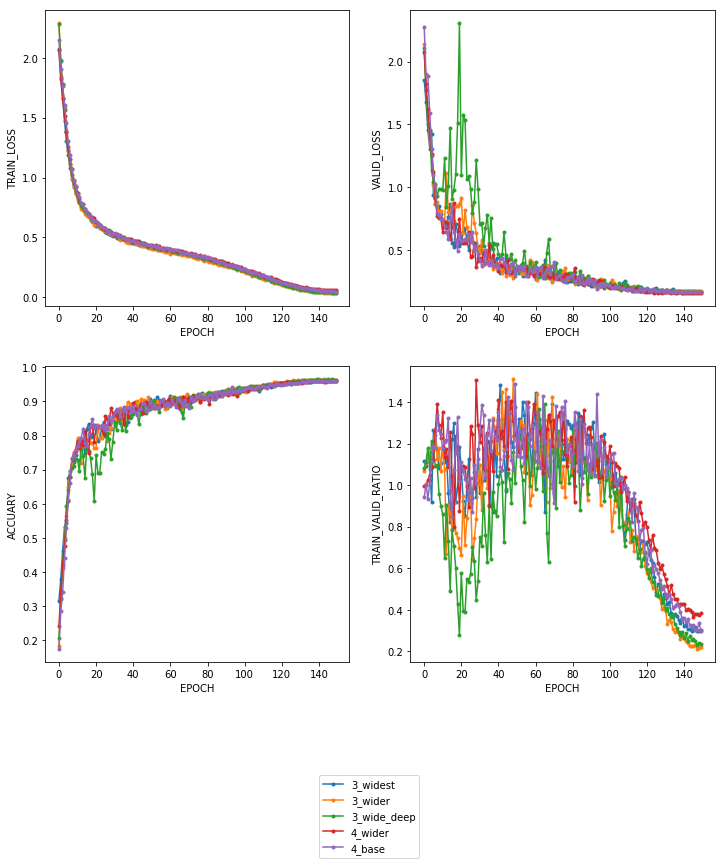

In [0]:
plot_df_groups(df_compare,sw_groups,4,marker=".")

Again let's zoom in.

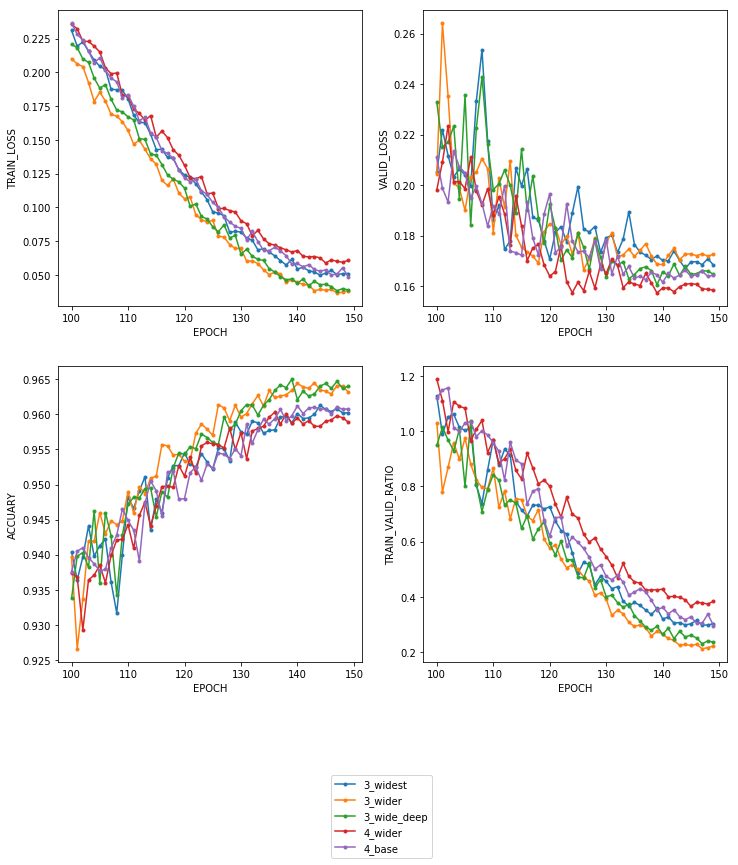

In [0]:
plot_df_groups(df_compare.tail(50),sw_groups,4,marker=".")

And zoom in, even more.

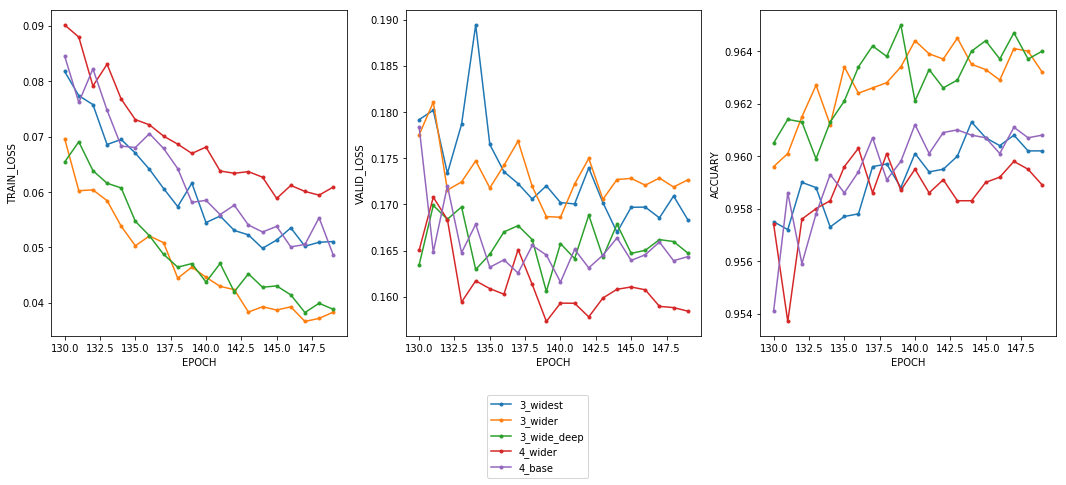

In [0]:
plot_df_groups(df_compare.tail(20),sw_groups,3,marker=".")

#### Summary

Every concat model has beaten wining kaggle original submission, which was 95.53%.  
Best model '3_wide_deep' achieved 96.47% accuracy, but during training it seemed the most unstable of all.   
Second best was '3_wider' with top accuracy 96.45%. At first look it could seem the best model of created ones.

If these models where further tuned they would probably beat 96.55% accuracy placing them for a brief period of time as State of Art for Cifar-10 as of 2017 year. (source: https://benchmarks.ai/cifar-10)

However in my opinion the most promising one is '4_wider'.   

Although after 150 epochs it had the worst accuracy of all, it is only as it fitted the least to data.  
At comparable value of train_loss , this model posses better validation loss, and comparable accuracy.  
This may suggest the most room for improvement.

Additionally It was the only model for which lr_find method suggested using learning rate set to 0.01.  
What's more '4_wider' gains the most of the concat pool idea, as it is implemented within first two subgroups and it is not implemented in 1st group.

Another valuable benefit is that 4 groups models runs more than 2 times faster compared to 3 groups. And after all, time is gold.


### Swish

We will now try 4_wider model with Swish as activation function.  
We will try many beta parameter for Swish from 0.5 up to 2.5.

Let's define Swish activation.

In [0]:
class Swish(nn.Module):

    def __init__(self, b = 1):
        super().__init__()
        self.b = b

    def forward(self, x):
        
        return nn.Sigmoid()(x) * x * self.b

#### ReLU vs Swish

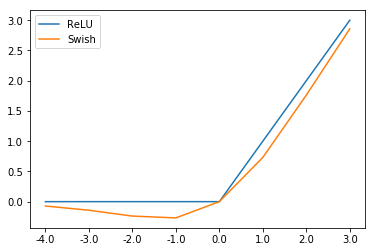

In [24]:
tensor_simple = np.linspace(-4,3,8)
tensor_simple = torch.from_numpy(tensor_simple)

plt.figsize=(7,7)
plt.plot(nn.ReLU()(tensor_simple))
plt.plot(Swish()(tensor_simple))
plt.xticks(np.arange(8),labels=np.linspace(-4,3,8))
plt.legend(labels=['ReLU',"Swish"])
plt.show()

In order to ease a bit of life, we will use 'get metrics' UDF to create 'get metrics and save to google drive' UDF

In [0]:
def get_metrics_save_to_disk(learn,name):
    df = get_training_metrics(learn)
    df.to_csv(f'/content/{name}.csv',sep="|")
    shutil.copy2(f'/content/{name}.csv',f'/content/gdrive/My Drive/{name}.csv')
    print(f'Metrics saved to google disk under name:\t{name}.csv')
    return df


#### Models

In [0]:
betas = np.linspace(.5,2.5,17)

In [0]:
archs = (WideResNet_Concat(
    num_groups=4,
    N=2,
    num_classes=len(data.classes),
    k=7,
    drop_p=[.1,.2,.3,.4],
    drop_m=[1.5],
    drop_last_p =.65,
    activation= Swish,
    activation_parameters={"b":beta}
    ) for beta in betas)

In [0]:
keys  = [(str(beta).replace(".","")+str(0))[:3] for beta in betas]

In [0]:
swish_models = {key:arch for key, arch in zip(keys, archs)}

If the models would be fitted one after another in one go, it would be smarter to create swish_models as generator comprehension instead dictionary. But as with two models I am going to get close to time limit for colab I am using the dictionary as I am going to connect multiple times anyway, and it is easier for me to specify model by key than loop over generator for target architecture.

In [0]:
learn_wrn_concat_4_sw050 = Learner(data, swish_models["050"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw050.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw062 = Learner(data, swish_models["062"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw062.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw075 = Learner(data, swish_models["075"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw075.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw087 = Learner(data, swish_models["087"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw087.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw100 = Learner(data, swish_models["100"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw100.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw112 = Learner(data, swish_models["112"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw112.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw125 = Learner(data, swish_models["125"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw125.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw137 = Learner(data, swish_models["137"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw137.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw150 = Learner(data, swish_models["150"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw150.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw162 = Learner(data, swish_models["162"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw162.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw175 = Learner(data, swish_models["175"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw175.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw187 = Learner(data, swish_models["187"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw187.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw200 = Learner(data, swish_models["200"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw200.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw212 = Learner(data, swish_models["212"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw212.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw225 = Learner(data, swish_models["225"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw225.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw237 = Learner(data, swish_models["237"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw237.to_fp16()
print()

In [0]:
learn_wrn_concat_4_sw250 = Learner(data, swish_models["250"].cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw250.to_fp16()
print()

Model looks very same for all architectures as the only thing we change is beta parameter, so this one applies to all above

In [0]:
learn_wrn_concat_4_sw250.summary()

WideResNet_Concat
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 32]         432        True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
Swish                [112, 32, 32]        0          False     
______________________________________________________________________
Conv2d               [112, 32, 32]        16,128     True      
______________________________________________________________________
BatchNorm2d          [112, 32, 32]        224        True      
______________________________________________________________________
Swish                [112, 32, 32]        0          False     
______________________________________________________________________
Conv2d               [112, 32, 32]        112,896    True      
____________________________________________

#### Lr_find

Before we start training let's release memory taken by swish models dictionary.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


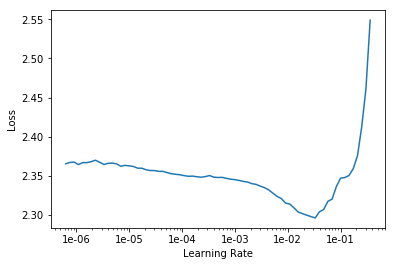

In [0]:
learn_wrn_concat_4_sw050.lr_find()
learn_wrn_concat_4_sw050.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


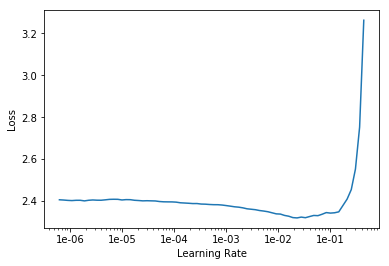

In [0]:
learn_wrn_concat_4_sw062.lr_find()
learn_wrn_concat_4_sw062.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


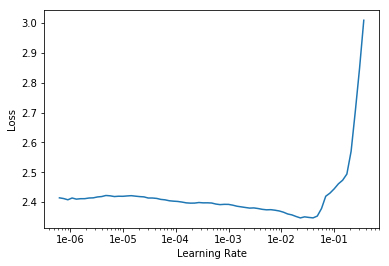

In [0]:
learn_wrn_concat_4_sw075.lr_find()
learn_wrn_concat_4_sw075.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


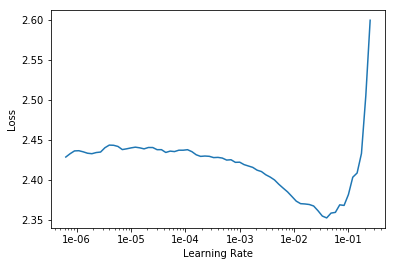

In [0]:
learn_wrn_concat_4_sw087.lr_find()
learn_wrn_concat_4_sw087.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


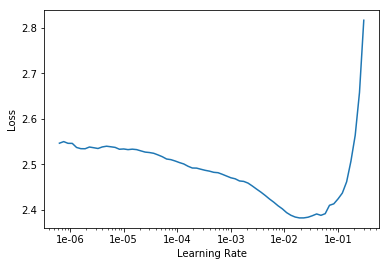

In [0]:
learn_wrn_concat_4_sw100.lr_find()
learn_wrn_concat_4_sw100.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


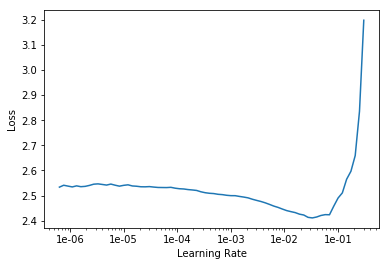

In [0]:
learn_wrn_concat_4_sw112.lr_find()
learn_wrn_concat_4_sw112.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


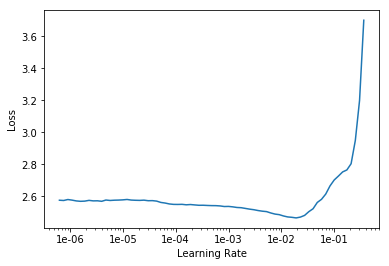

In [0]:
learn_wrn_concat_4_sw125.lr_find()
learn_wrn_concat_4_sw125.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


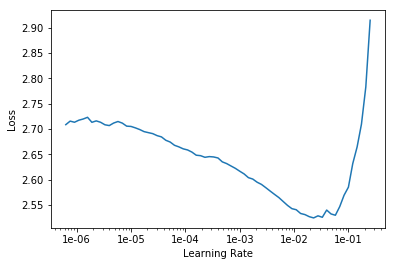

In [0]:
learn_wrn_concat_4_sw137.lr_find()
learn_wrn_concat_4_sw137.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


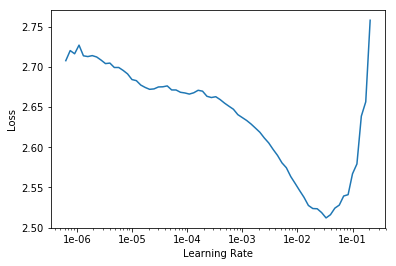

In [0]:
learn_wrn_concat_4_sw150.lr_find()
learn_wrn_concat_4_sw150.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


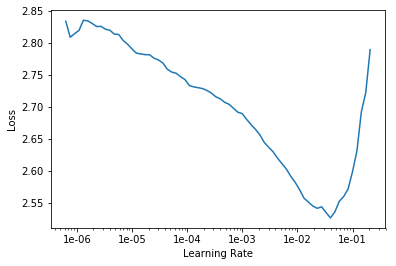

In [0]:
learn_wrn_concat_4_sw162.lr_find()
learn_wrn_concat_4_sw162.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


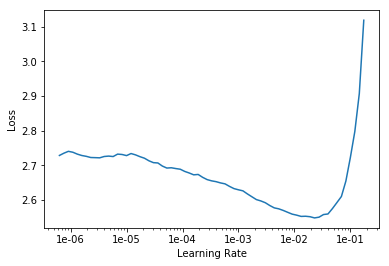

In [0]:
learn_wrn_concat_4_sw175.lr_find()
learn_wrn_concat_4_sw175.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


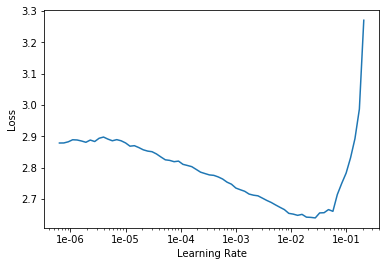

In [0]:
learn_wrn_concat_4_sw187.lr_find()
learn_wrn_concat_4_sw187.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


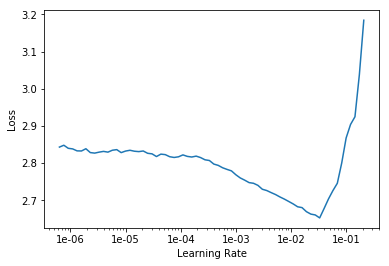

In [0]:
learn_wrn_concat_4_sw200.lr_find()
learn_wrn_concat_4_sw200.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


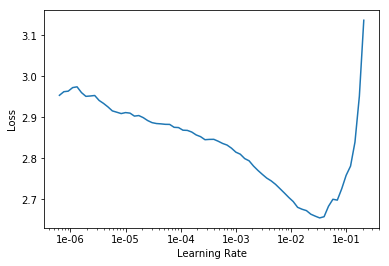

In [0]:
learn_wrn_concat_4_sw212.lr_find()
learn_wrn_concat_4_sw212.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


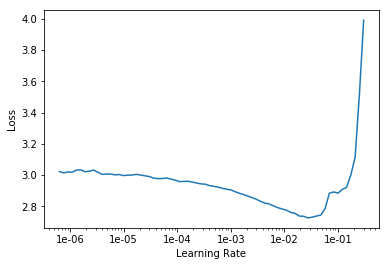

In [0]:
learn_wrn_concat_4_sw225.lr_find()
learn_wrn_concat_4_sw225.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


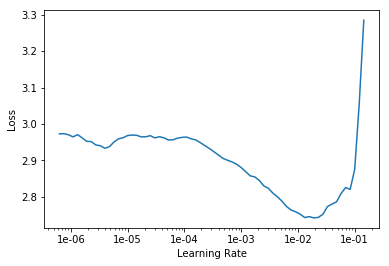

In [0]:
learn_wrn_concat_4_sw237.lr_find()
learn_wrn_concat_4_sw237.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


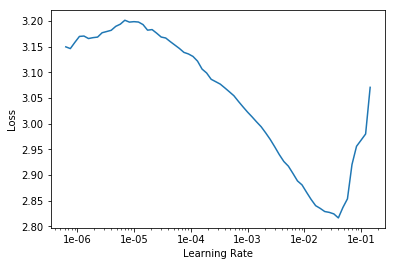

In [0]:
learn_wrn_concat_4_sw250.lr_find()
learn_wrn_concat_4_sw250.recorder.plot()

#### Fitting model

In [0]:
learn_wrn_concat_4_sw050.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_4_sw050 = get_metrics_save_to_disk(learn_wrn_concat_4_sw050,'df_wrn_concat_4_sw050')

Metrics saved to google disk under name:	df_wrn_concat_4_sw050.csv


In [0]:
learn_wrn_concat_4_sw062.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_4_sw062 = get_metrics_save_to_disk(learn_wrn_concat_4_sw062,'df_wrn_concat_4_sw062')

Metrics saved to google disk under name:	df_wrn_concat_4_sw062.csv


In [0]:
learn_wrn_concat_4_sw075.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

In [0]:
df_wrn_concat_4_sw075 = get_metrics_save_to_disk(learn_wrn_concat_4_sw075,'df_wrn_concat_4_sw075')

Metrics saved to google disk under name:	df_wrn_concat_4_sw075.csv


In [0]:
learn_wrn_concat_4_sw087.fit_one_cycle(150,max_lr=3e-03,wd=0.1)


Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_4_sw087 = get_metrics_save_to_disk(learn_wrn_concat_4_sw087,'df_wrn_concat_4_sw087')


Metrics saved to google disk under name:	df_wrn_concat_4_sw087.csv


In [0]:
learn_wrn_concat_4_sw100.fit_one_cycle(150,max_lr=3e-03,wd=0.1)


In [0]:
df_wrn_concat_4_sw100 = get_metrics_save_to_disk(learn_wrn_concat_4_sw100,'df_wrn_concat_4_sw100')


Metrics saved to google disk under name:	df_wrn_concat_4_sw100.csv


In [0]:
learn_wrn_concat_4_sw112.fit_one_cycle(150,max_lr=3e-03,wd=0.1)


Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_4_sw112 = get_metrics_save_to_disk(learn_wrn_concat_4_sw112,'df_wrn_concat_4_sw112')


Metrics saved to google disk under name:	df_wrn_concat_4_sw112.csv


In [0]:
learn_wrn_concat_4_sw125.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

In [0]:
df_wrn_concat_4_sw125 = get_metrics_save_to_disk(learn_wrn_concat_4_sw125,'df_wrn_concat_4_sw125')

Metrics saved to google disk under name:	df_wrn_concat_4_sw125.csv


In [0]:
learn_wrn_concat_4_sw137.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

In [0]:
df_wrn_concat_4_sw137 = get_metrics_save_to_disk(learn_wrn_concat_4_sw137,'df_wrn_concat_4_sw137')

Metrics saved to google disk under name:	df_wrn_concat_4_sw137.csv


In [0]:
learn_wrn_concat_4_sw150.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_4_sw150 = get_metrics_save_to_disk(learn_wrn_concat_4_sw150,'df_wrn_concat_4_sw150')

Metrics saved to google disk under name:	df_wrn_concat_4_sw150.csv


In [0]:
learn_wrn_concat_4_sw162.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

In [0]:
df_wrn_concat_4_sw162 = get_metrics_save_to_disk(learn_wrn_concat_4_sw162,'df_wrn_concat_4_sw162')

Metrics saved to google disk under name:	df_wrn_concat_4_sw162.csv


In [0]:
learn_wrn_concat_4_sw175.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_4_sw175 = get_metrics_save_to_disk(learn_wrn_concat_4_sw175,'df_wrn_concat_4_sw175')

Metrics saved to google disk under name:	df_wrn_concat_4_sw175.csv


In [0]:
learn_wrn_concat_4_sw187.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_4_sw187 = get_metrics_save_to_disk(learn_wrn_concat_4_sw187,'df_wrn_concat_4_sw187')

Metrics saved to google disk under name:	df_wrn_concat_4_sw187.csv


In [0]:
learn_wrn_concat_4_sw200.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

In [0]:
df_wrn_concat_4_sw200 = get_metrics_save_to_disk(learn_wrn_concat_4_sw200,'df_wrn_concat_4_sw200')

Metrics saved to google disk under name:	df_wrn_concat_4_sw200.csv


In [0]:
learn_wrn_concat_4_sw212.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

In [0]:
df_wrn_concat_4_sw212 = get_metrics_save_to_disk(learn_wrn_concat_4_sw212,'df_wrn_concat_4_sw212')

Metrics saved to google disk under name:	df_wrn_concat_4_sw212.csv


In [0]:
learn_wrn_concat_4_sw225.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

In [0]:
df_wrn_concat_4_sw225 = get_metrics_save_to_disk(learn_wrn_concat_4_sw225,'df_wrn_concat_4_sw225')

Metrics saved to google disk under name:	df_wrn_concat_4_sw225.csv


In [0]:
learn_wrn_concat_4_sw237.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

In [0]:
df_wrn_concat_4_sw237 = get_metrics_save_to_disk(learn_wrn_concat_4_sw237,'df_wrn_concat_4_sw237')

Metrics saved to google disk under name:	df_wrn_concat_4_sw237.csv


In [0]:
learn_wrn_concat_4_sw250.fit_one_cycle(150,max_lr=3e-03,wd=0.1)

Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_4_sw250 = get_metrics_save_to_disk(learn_wrn_concat_4_sw250,'df_wrn_concat_4_sw250')

Metrics saved to google disk under name:	df_wrn_concat_4_sw250.csv


#### Comparision

In [0]:
def join_multi_csv(paths,suffixes,sep:str="|"):
    dfs = [pd.read_csv(path, sep=sep,index_col=[0],engine='c' ) for path in paths]
    
    out = dfs[0]
    i=0
    for df in dfs[1:]:
        i+=1 
        if i<len(paths)-1:
            out = out.join(df,lsuffix="",rsuffix=suffixes[i])
        else:
            out = out.join(df,lsuffix=suffixes[0],rsuffix=suffixes[i])
    return out





In [0]:
paths = [
    'df_wrn_concat_4_sw050.csv',
    'df_wrn_concat_4_sw062.csv',
    'df_wrn_concat_4_sw075.csv',
    'df_wrn_concat_4_sw087.csv',
    'df_wrn_concat_4_sw100.csv',
    'df_wrn_concat_4_sw112.csv',
    'df_wrn_concat_4_sw125.csv',
    'df_wrn_concat_4_sw137.csv',
    'df_wrn_concat_4_sw150.csv',
    'df_wrn_concat_4_sw162.csv',
    'df_wrn_concat_4_sw175.csv',
    'df_wrn_concat_4_sw187.csv',
    'df_wrn_concat_4_sw200.csv',
    'df_wrn_concat_4_sw212.csv',
    'df_wrn_concat_4_sw225.csv',
    'df_wrn_concat_4_sw237.csv',
    'df_wrn_concat_4_sw250.csv'
]
suffixes = [
    '_050',
    '_062',
    '_075',
    '_087',
    '_100',
    '_112',
    '_125',
    '_137',
    '_150',
    '_162',
    '_175',
    '_187',
    '_200',
    '_212',
    '_225',
    '_237',
    '_250'
]

os.chdir('/content/gdrive/My Drive/')


df_compare = join_multi_csv(paths,suffixes)


In [0]:
df_compare.tail(10).T.iloc[0:36,:]

140       141  ...       148       149
train_loss_050         0.099312  0.097885  ...  0.092596  0.096718
valid_loss_050         0.154967  0.152340  ...  0.154711  0.155045
accuracy_050            0.955200  0.955700  ...  0.956100  0.955900
train_valid_ratio_050  0.640858  0.642545  ...  0.598510  0.623809
train_loss_062         0.099281  0.097652  ...  0.087939  0.092295
valid_loss_062         0.159771  0.159350  ...  0.160269  0.158800
accuracy_062            0.954600  0.955100  ...  0.957100  0.956300
train_valid_ratio_062  0.621395  0.612811  ...  0.548692  0.581204
train_loss_075         0.092796  0.094131  ...  0.087328  0.091714
valid_loss_075         0.175450  0.174616  ...  0.169498  0.171567
accuracy_075            0.953200  0.952700  ...  0.954000  0.953900
train_valid_ratio_075  0.528906  0.539072  ...  0.515216  0.534568
train_loss_087         0.097387  0.096236  ...  0.093358  0.086821
valid_loss_087         0.172933  0.176791  ...  0.174331  0.174728
accuracy_087            0.953200  0.953200  ...  0.953900  0.953800
train_valid_ratio_087  0.563152  0.544352  ...  0.535519  0.496895
train_loss_100         0.099792  0.104743  ...  0.092471  0.091821
valid_loss_100         0.182942  0.179192  ...  0.179464  0.182002
accuracy_100            0.953000  0.952600  ...  0.953300  0.953100
train_valid_ratio_100  0.545484  0.584526  ...  0.515265  0.504504
train_loss_112         0.097829  0.099480  ...  0.092151  0.092787
valid_loss_112         0.174422  0.178874  ...  0.171641  0.172719
accuracy_112            0.954500  0.953300  ...  0.955500  0.955200
train_valid_ratio_112  0.560874  0.556149  ...  0.536882  0.537214
train_loss_125         0.105832  0.098381  ...  0.092792  0.094411
valid_loss_125         0.164630  0.163561  ...  0.163274  0.162782
accuracy_125            0.953100  0.954800  ...  0.955100  0.954900
train_valid_ratio_125  0.642846  0.601492  ...  0.568319  0.579989
train_loss_137         0.101371  0.096423  ...  0.097582  0.094005
valid_loss_137         0.171458  0.169872  ...  0.170050  0.170207
accuracy_137            0.953100  0.954800  ...  0.954900  0.954400
train_valid_ratio_137  0.591230  0.567622  ...  0.573843  0.552300
train_loss_150         0.103630  0.102101  ...  0.097920  0.096505
valid_loss_150         0.174718  0.177890  ...  0.174068  0.175017
accuracy_150            0.953900  0.954000  ...  0.954700  0.955100
train_valid_ratio_150  0.593128  0.573955  ...  0.562537  0.551402

[36 rows x 10 columns]

In [0]:
df_compare.tail(10).T.iloc[36:,:]

140       141  ...       148       149
train_loss_162         0.102795  0.106609  ...  0.097472  0.102069
valid_loss_162         0.178566  0.181991  ...  0.178741  0.177994
accuracy_162            0.953900  0.953600  ...  0.953700  0.953800
train_valid_ratio_162  0.575668  0.585791  ...  0.545324  0.573441
train_loss_175         0.103686  0.100362  ...  0.100348  0.094975
valid_loss_175         0.166614  0.172628  ...  0.169066  0.166860
accuracy_175            0.954500  0.954200  ...  0.955700  0.955700
train_valid_ratio_175  0.622311  0.581377  ...  0.593544  0.569188
train_loss_187         0.105915  0.104951  ...  0.099301  0.096981
valid_loss_187         0.178779  0.180726  ...  0.176782  0.177986
accuracy_187            0.952900  0.953800  ...  0.955500  0.954900
train_valid_ratio_187  0.592435  0.580721  ...  0.561716  0.544879
train_loss_200         0.102711  0.102903  ...  0.102711  0.101131
valid_loss_200         0.177824  0.177719  ...  0.172733  0.172304
accuracy_200            0.954800  0.954800  ...  0.956700  0.955900
train_valid_ratio_200  0.577599  0.579023  ...  0.594622  0.586935
train_loss_212         0.107600  0.105859  ...  0.096412  0.100320
valid_loss_212         0.180547  0.174810  ...  0.174647  0.176105
accuracy_212            0.951200  0.951700  ...  0.952500  0.952200
train_valid_ratio_212  0.595966  0.605565  ...  0.552040  0.569664
train_loss_225         0.108965  0.103381  ...  0.099806  0.098287
valid_loss_225         0.178886  0.173949  ...  0.177725  0.172809
accuracy_225            0.954100  0.955200  ...  0.954800  0.954800
train_valid_ratio_225  0.609132  0.594321  ...  0.561576  0.568760
train_loss_237         0.108061  0.105986  ...  0.101366  0.097854
valid_loss_237         0.177616  0.170160  ...  0.170266  0.171744
accuracy_237            0.949500  0.951500  ...  0.952200  0.952400
train_valid_ratio_237  0.608400  0.622862  ...  0.595336  0.569771
train_loss_250         0.109416  0.109666  ...  0.100987  0.103417
valid_loss_250         0.175129  0.179994  ...  0.173140  0.175968
accuracy_250            0.953000  0.953500  ...  0.954400  0.954100
train_valid_ratio_250  0.624775  0.609278  ...  0.583266  0.587704

[32 rows x 10 columns]

Sorted by metric

In [0]:
df_compare.tail(10).T.sort_index().iloc[0:34,:]

140       141       142  ...       147       148       149
accuracy_050     0.955200  0.955700  0.955700  ...  0.956100  0.956100  0.955900
accuracy_062     0.954600  0.955100  0.956400  ...  0.956200  0.957100  0.956300
accuracy_075     0.953200  0.952700  0.955700  ...  0.955000  0.954000  0.953900
accuracy_087     0.953200  0.953200  0.954100  ...  0.954300  0.953900  0.953800
accuracy_100     0.953000  0.952600  0.953300  ...  0.953400  0.953300  0.953100
accuracy_112     0.954500  0.953300  0.956300  ...  0.955100  0.955500  0.955200
accuracy_125     0.953100  0.954800  0.955900  ...  0.954100  0.955100  0.954900
accuracy_137     0.953100  0.954800  0.953600  ...  0.954500  0.954900  0.954400
accuracy_150     0.953900  0.954000  0.954200  ...  0.954800  0.954700  0.955100
accuracy_162     0.953900  0.953600  0.952600  ...  0.953200  0.953700  0.953800
accuracy_175     0.954500  0.954200  0.954600  ...  0.955700  0.955700  0.955700
accuracy_187     0.952900  0.953800  0.953600  ...  0.955600  0.955500  0.954900
accuracy_200     0.954800  0.954800  0.954000  ...  0.956400  0.956700  0.955900
accuracy_212     0.951200  0.951700  0.952400  ...  0.952500  0.952500  0.952200
accuracy_225     0.954100  0.955200  0.954100  ...  0.954500  0.954800  0.954800
accuracy_237     0.949500  0.951500  0.951100  ...  0.952600  0.952200  0.952400
accuracy_250     0.953000  0.953500  0.954100  ...  0.953800  0.954400  0.954100
train_loss_050  0.099312  0.097885  0.095527  ...  0.093177  0.092596  0.096718
train_loss_062  0.099281  0.097652  0.095165  ...  0.093141  0.087939  0.092295
train_loss_075  0.092796  0.094131  0.095547  ...  0.091976  0.087328  0.091714
train_loss_087  0.097387  0.096236  0.096127  ...  0.087302  0.093358  0.086821
train_loss_100  0.099792  0.104743  0.096343  ...  0.092280  0.092471  0.091821
train_loss_112  0.097829  0.099480  0.097833  ...  0.097123  0.092151  0.092787
train_loss_125  0.105832  0.098381  0.097647  ...  0.093965  0.092792  0.094411
train_loss_137  0.101371  0.096423  0.095223  ...  0.094102  0.097582  0.094005
train_loss_150  0.103630  0.102101  0.098268  ...  0.098505  0.097920  0.096505
train_loss_162  0.102795  0.106609  0.101730  ...  0.094193  0.097472  0.102069
train_loss_175  0.103686  0.100362  0.097177  ...  0.097854  0.100348  0.094975
train_loss_187  0.105915  0.104951  0.098468  ...  0.103594  0.099301  0.096981
train_loss_200  0.102711  0.102903  0.102584  ...  0.093042  0.102711  0.101131
train_loss_212  0.107600  0.105859  0.099869  ...  0.102834  0.096412  0.100320
train_loss_225  0.108965  0.103381  0.107934  ...  0.101354  0.099806  0.098287
train_loss_237  0.108061  0.105986  0.102472  ...  0.100268  0.101366  0.097854
train_loss_250  0.109416  0.109666  0.104689  ...  0.104633  0.100987  0.103417

[34 rows x 10 columns]

In [0]:
df_compare.tail(10).T.sort_index().iloc[34:,:]

140       141  ...       148       149
train_valid_ratio_050  0.640858  0.642545  ...  0.598510  0.623809
train_valid_ratio_062  0.621395  0.612811  ...  0.548692  0.581204
train_valid_ratio_075  0.528906  0.539072  ...  0.515216  0.534568
train_valid_ratio_087  0.563152  0.544352  ...  0.535519  0.496895
train_valid_ratio_100  0.545484  0.584526  ...  0.515265  0.504504
train_valid_ratio_112  0.560874  0.556149  ...  0.536882  0.537214
train_valid_ratio_125  0.642846  0.601492  ...  0.568319  0.579989
train_valid_ratio_137  0.591230  0.567622  ...  0.573843  0.552300
train_valid_ratio_150  0.593128  0.573955  ...  0.562537  0.551402
train_valid_ratio_162  0.575668  0.585791  ...  0.545324  0.573441
train_valid_ratio_175  0.622311  0.581377  ...  0.593544  0.569188
train_valid_ratio_187  0.592435  0.580721  ...  0.561716  0.544879
train_valid_ratio_200  0.577599  0.579023  ...  0.594622  0.586935
train_valid_ratio_212  0.595966  0.605565  ...  0.552040  0.569664
train_valid_ratio_225  0.609132  0.594321  ...  0.561576  0.568760
train_valid_ratio_237  0.608400  0.622862  ...  0.595336  0.569771
train_valid_ratio_250  0.624775  0.609278  ...  0.583266  0.587704
valid_loss_050         0.154967  0.152340  ...  0.154711  0.155045
valid_loss_062         0.159771  0.159350  ...  0.160269  0.158800
valid_loss_075         0.175450  0.174616  ...  0.169498  0.171567
valid_loss_087         0.172933  0.176791  ...  0.174331  0.174728
valid_loss_100         0.182942  0.179192  ...  0.179464  0.182002
valid_loss_112         0.174422  0.178874  ...  0.171641  0.172719
valid_loss_125         0.164630  0.163561  ...  0.163274  0.162782
valid_loss_137         0.171458  0.169872  ...  0.170050  0.170207
valid_loss_150         0.174718  0.177890  ...  0.174068  0.175017
valid_loss_162         0.178566  0.181991  ...  0.178741  0.177994
valid_loss_175         0.166614  0.172628  ...  0.169066  0.166860
valid_loss_187         0.178779  0.180726  ...  0.176782  0.177986
valid_loss_200         0.177824  0.177719  ...  0.172733  0.172304
valid_loss_212         0.180547  0.174810  ...  0.174647  0.176105
valid_loss_225         0.178886  0.173949  ...  0.177725  0.172809
valid_loss_237         0.177616  0.170160  ...  0.170266  0.171744
valid_loss_250         0.175129  0.179994  ...  0.173140  0.175968

[34 rows x 10 columns]

We will change the legend placement for 4 subplots as with so many groups it will be easier to have legend on the side to plots instead below them.

In [0]:
def plot_4_subplots(df,sw_groups,groups,marker):
  fig, axs = plt.subplots(2,2, figsize=(12,12))

  axs_unpacked = []
  for level in axs:
    axs_unpacked.extend(level)
  
  for col in df.columns:
    for i in range(len(axs_unpacked)):
      if col.startswith(sw_groups[i]):
        axs_unpacked[i].plot(df[col],marker=marker)
    
  for i in range(len(axs_unpacked)):
    axs_unpacked[i].set_xlabel('EPOCH')
    axs_unpacked[i].set_ylabel(sw_groups[i].upper())   
      
  plt.legend(labels=groups, loc='upper center', bbox_to_anchor=(1, 0.7), bbox_transform=plt.gcf().transFigure)
  plt.show()

In [0]:
sw_groups = ["train_loss",
"valid_loss",
"accuracy",
"train_valid_ratio"]

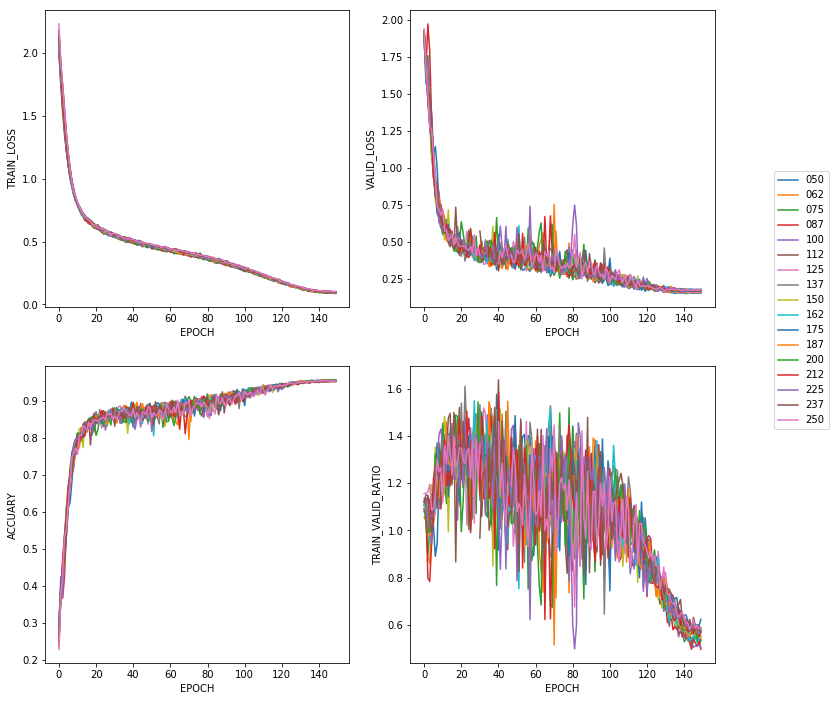

In [0]:
plot_df_groups(df_compare,sw_groups,4)

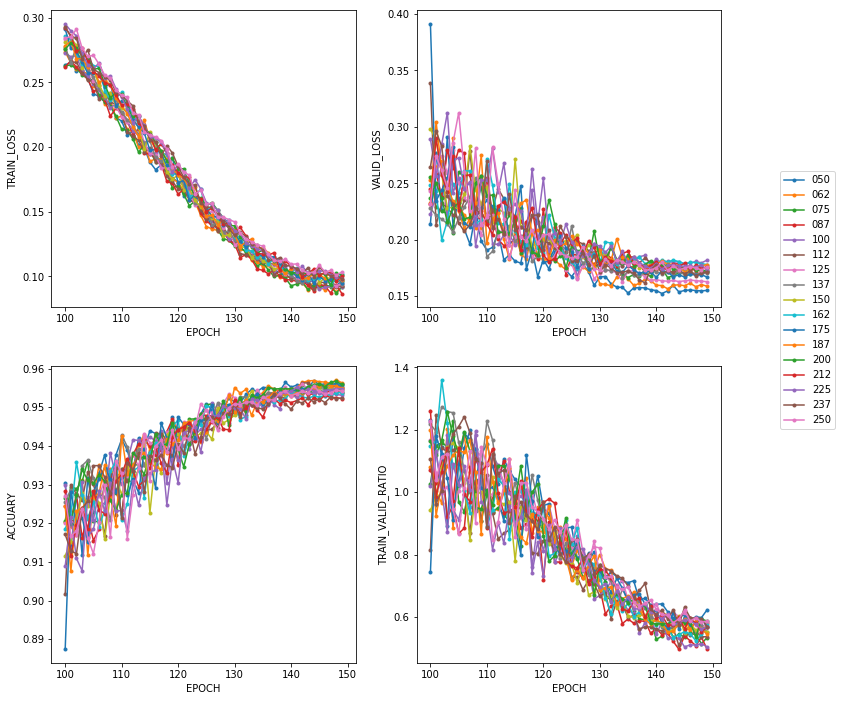

In [0]:
plot_df_groups(df_compare.tail(50),sw_groups,4,marker=".")

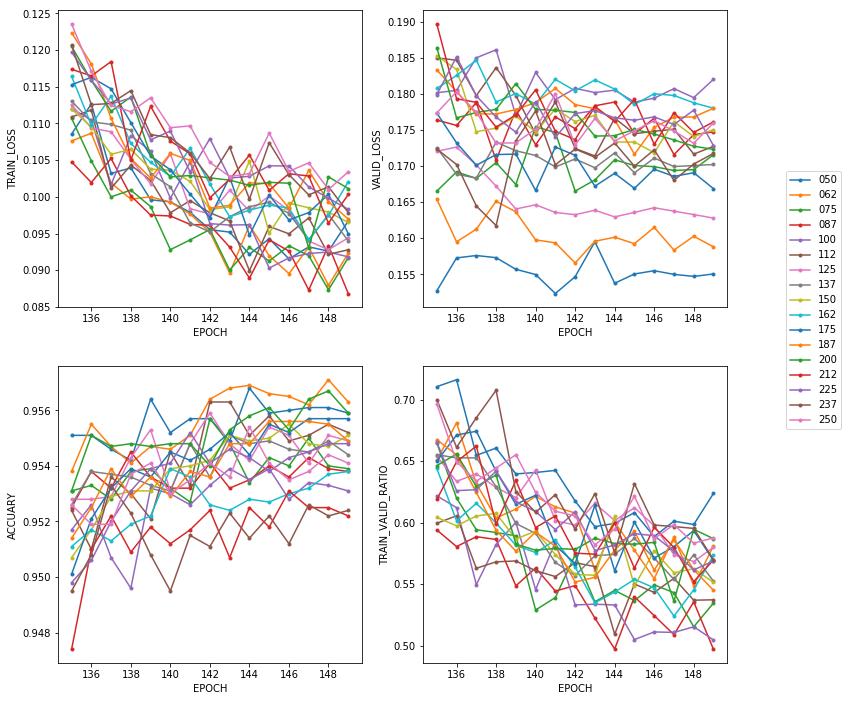

In [0]:
plot_df_groups(df_compare.tail(15),sw_groups,4,marker=".")

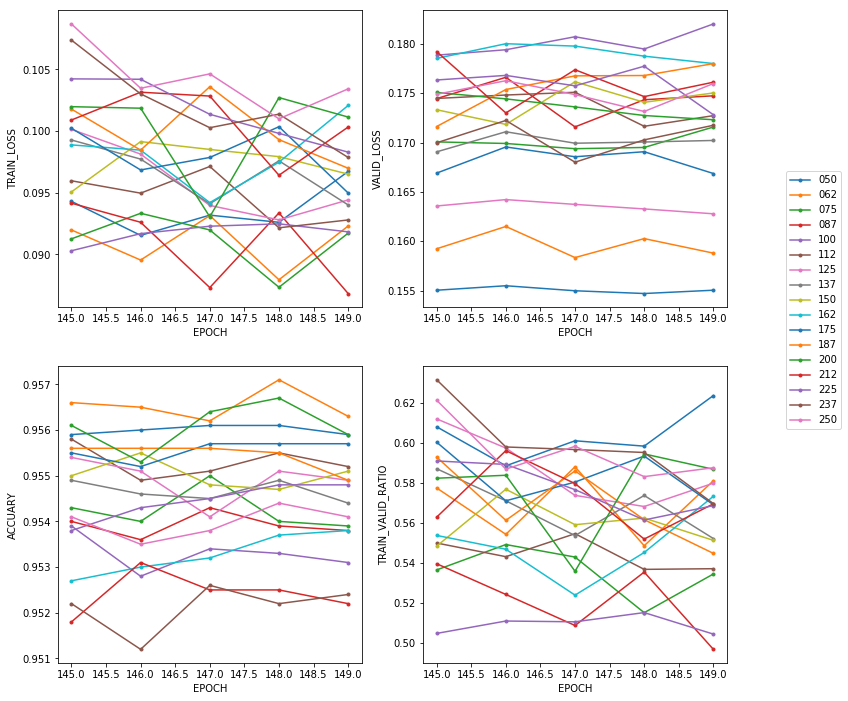

In [0]:
plot_df_groups(df_compare.tail(5),sw_groups,4,marker=".")

We will read each metrics .csv separately instead one big dataframe.

In [0]:
betas = np.linspace(.5,2.5,17)
keys  = [(str(beta).replace(".","")+str(0))[:3] for beta in betas]

In [0]:
dfs = {key:pd.read_csv(path, sep="|",engine="c", index_col=[0]) for key,path in zip(keys,paths)}

In [0]:
for key in dfs.keys():
  dfs[key]['train_acc_ratio'] = dfs[key]['train_loss']/ dfs[key]['accuracy']

Checking for NaN's in fitting

In [0]:
for key in dfs.keys():
  print(f'Swish model with beta = {float(key)/100}')
  print(dfs[key][dfs[key]['valid_loss'].isna()].count())
  print("_"*20)

Swish model with beta = 0.5
train_loss           0
valid_loss           0
accuracy              0
train_valid_ratio    0
train_acc_ratio      0
dtype: int64
____________________
Swish model with beta = 0.62
train_loss           0
valid_loss           0
accuracy              0
train_valid_ratio    0
train_acc_ratio      0
dtype: int64
____________________
Swish model with beta = 0.75
train_loss           0
valid_loss           0
accuracy              0
train_valid_ratio    0
train_acc_ratio      0
dtype: int64
____________________
Swish model with beta = 0.87
train_loss           0
valid_loss           0
accuracy              0
train_valid_ratio    0
train_acc_ratio      0
dtype: int64
____________________
Swish model with beta = 1.0
train_loss           0
valid_loss           0
accuracy              0
train_valid_ratio    0
train_acc_ratio      0
dtype: int64
____________________
Swish model with beta = 1.12
train_loss           0
valid_loss           0
accuracy              0
train_va

In [0]:
dfs['237'][dfs['237']['valid_loss'].isna()]

train_loss  valid_loss  accuracy  train_valid_ratio  train_acc_ratio
26    0.577151         NaN   0.8558                NaN         0.674400
27    0.568842         NaN   0.8585                NaN         0.662599
29    0.566455         NaN   0.8687                NaN         0.652072
33    0.536406         NaN   0.8724                NaN         0.614862
34    0.527444         NaN   0.8560                NaN         0.616172

In [0]:
dfs['250'][dfs['250']['valid_loss'].isna()]

train_loss  valid_loss  accuracy  train_valid_ratio  train_acc_ratio
31    0.560814         NaN   0.8498                NaN         0.659937
32    0.536404         NaN   0.8616                NaN         0.622567
33    0.544250         NaN   0.8740                NaN         0.622712
34    0.534009         NaN   0.8724                NaN         0.612115
36    0.525687         NaN   0.8737                NaN         0.601679
37    0.521528         NaN   0.8681                NaN         0.600769
38    0.521396         NaN   0.8599                NaN         0.606345
39    0.521815         NaN   0.8602                NaN         0.606621
46    0.487852         NaN   0.8678                NaN         0.562171

Although at early epochs models with beta parameter equal to 2.37 and 2.5 had NaN's for valid loss both of them stabilized and we are not going to reject these from further analysis.

In [0]:
def join_multi_dfs(dfs):
  temp = list(dfs.items())
  suffixes = []
  dfs = []
  for key, df in temp:
    suffixes.append(f'_{key}')
    dfs.append(df)
  out = dfs[0]
  i=0
  for df in dfs[1:]:
      i+=1 
      if i<len(paths)-1:
          out = out.join(df,lsuffix="",rsuffix=suffixes[i])
      else:
          out = out.join(df,lsuffix=suffixes[0],rsuffix=suffixes[i])
  return out


In [0]:
df_compare_new = join_multi_dfs(dfs)

In [0]:
sw_groups = ["train_loss",
"accuracy",
"train_acc_ratio",
"train_valid_ratio"]

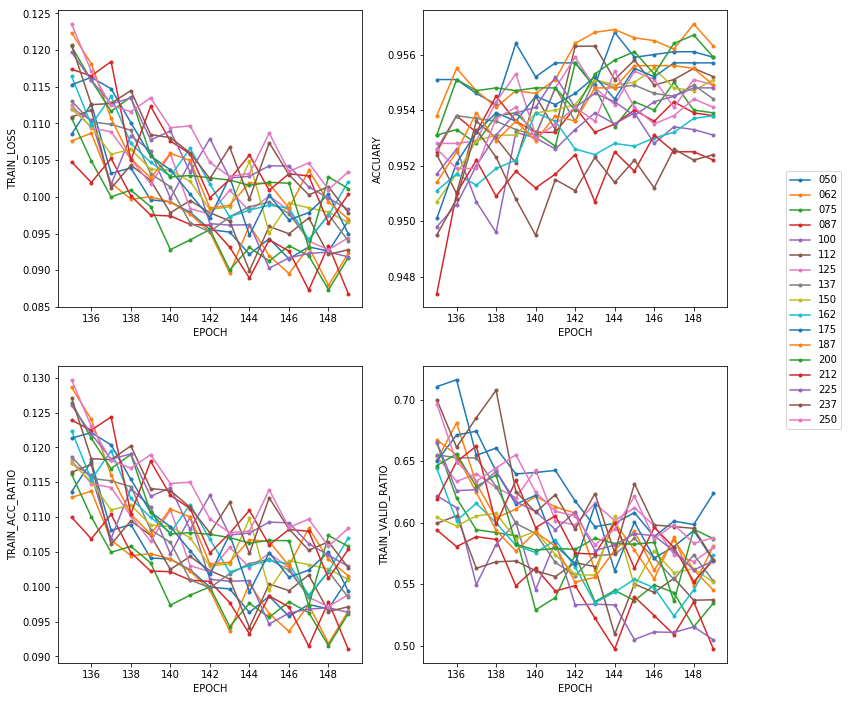

In [0]:
plot_df_groups(df_compare_new.tail(15),sw_groups,4,marker=".")

In [0]:
dfs_slices = {key:dfs[key][dfs[key]['train_loss'] < 0.12].reset_index(drop=True) for key in dfs.keys()}

In [0]:
df_compare_slices = join_multi_dfs(dfs_slices)

In [0]:
df_compare_slices.T.describe().iloc[0] / 5

0     17.0
1     17.0
2     17.0
3     17.0
4     17.0
5     17.0
6     17.0
7     17.0
8     17.0
9     17.0
10    17.0
11    17.0
12    17.0
13    17.0
14    14.0
15    12.0
16     9.0
17     5.0
Name: count, dtype: float64

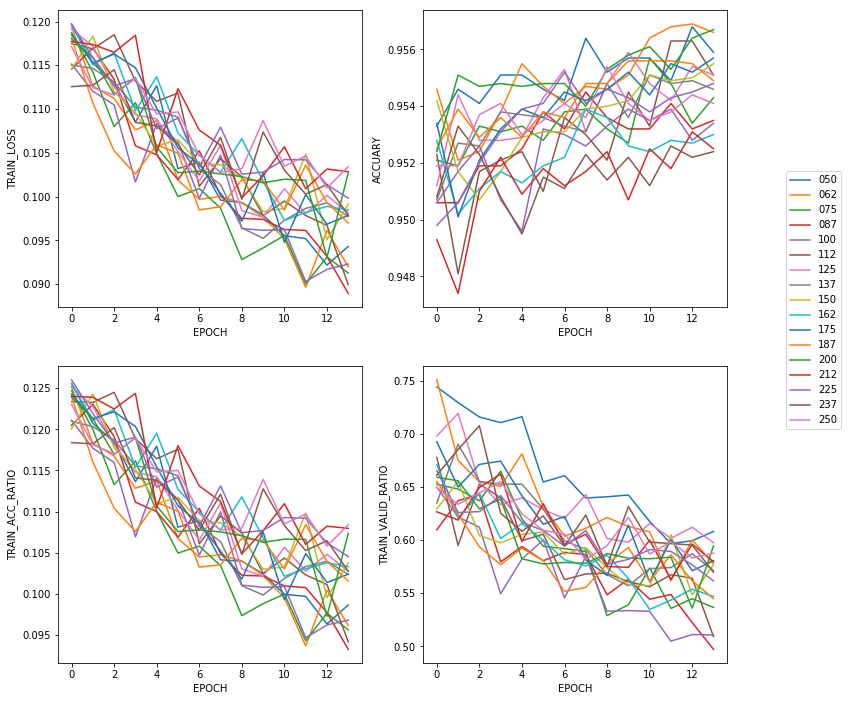

In [0]:
plot_df_groups(df_compare_slices.head(14),sw_groups,4,marker="")

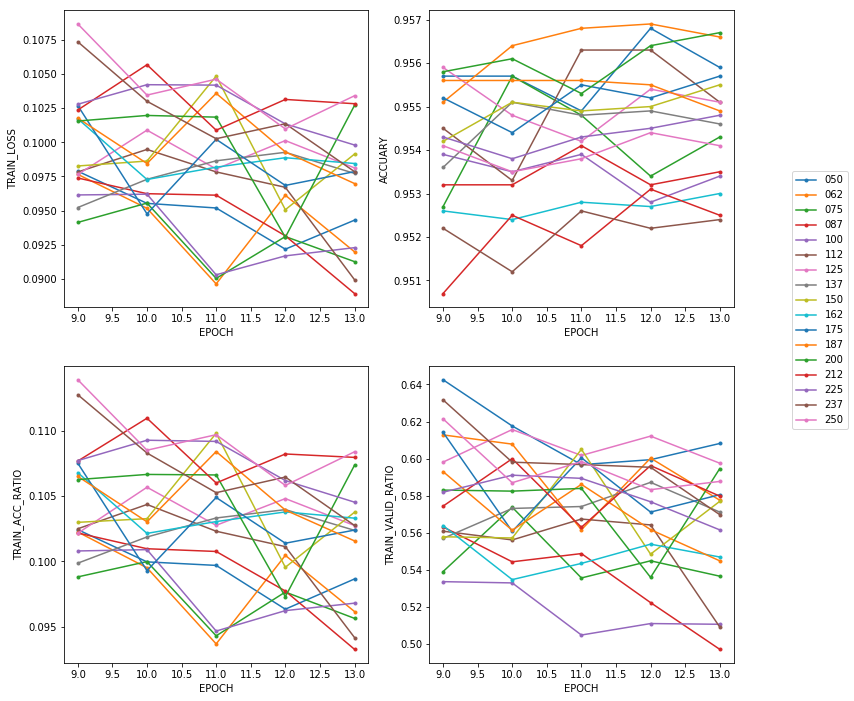

In [0]:
plot_df_groups(df_compare_slices.head(14).tail(5),sw_groups,4,marker=".")

As plots with all models are unreadable we will divide them into two groups from which we will chose.

In [0]:
df_compare_slices_part1 = df_compare_slices.iloc[:,:40]

In [0]:
df_compare_slices_part2 = df_compare_slices.iloc[:,40:]

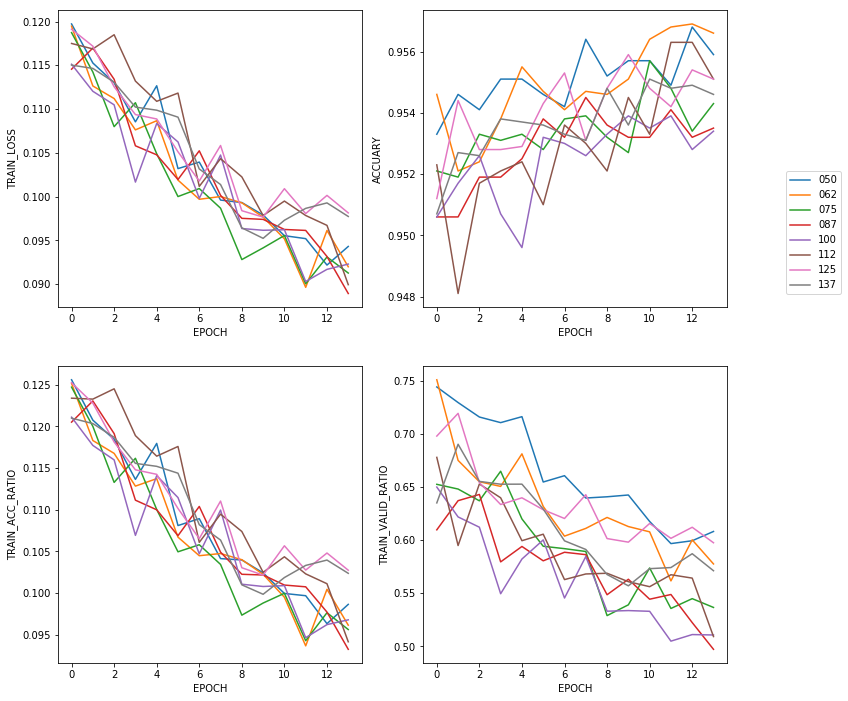

In [0]:
plot_df_groups(df_compare_slices_part1.head(14),sw_groups,4,marker="")

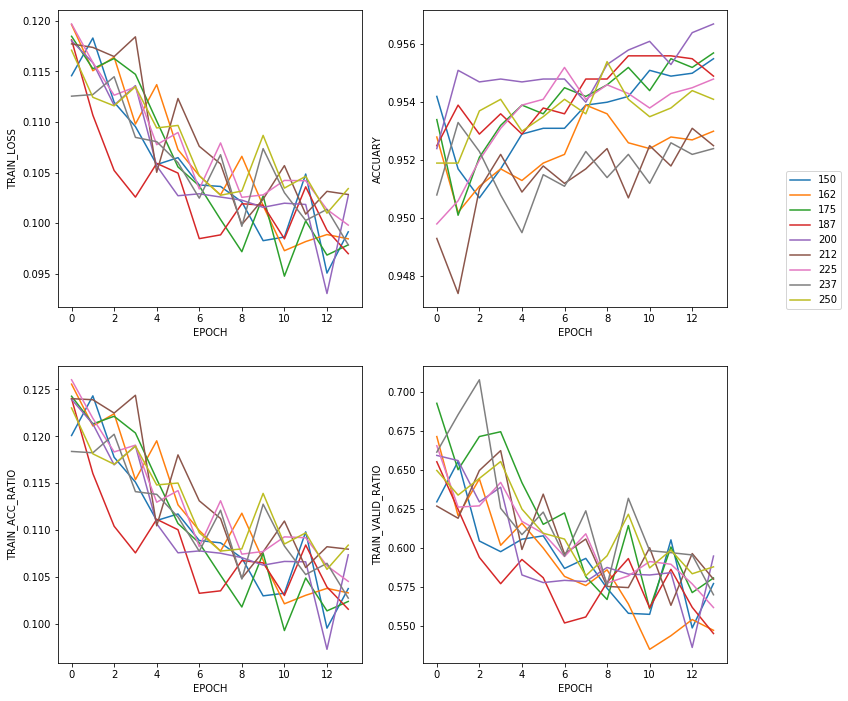

In [0]:
plot_df_groups(df_compare_slices_part2.head(14),sw_groups,4,marker="")

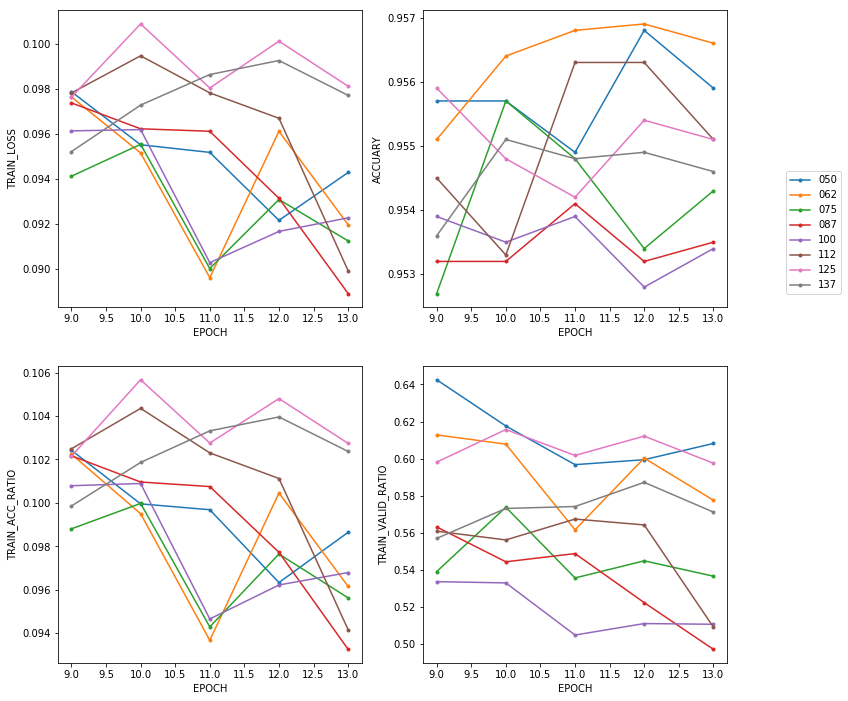

In [0]:
plot_df_groups(df_compare_slices_part1.head(14).tail(5),sw_groups,4,marker=".")

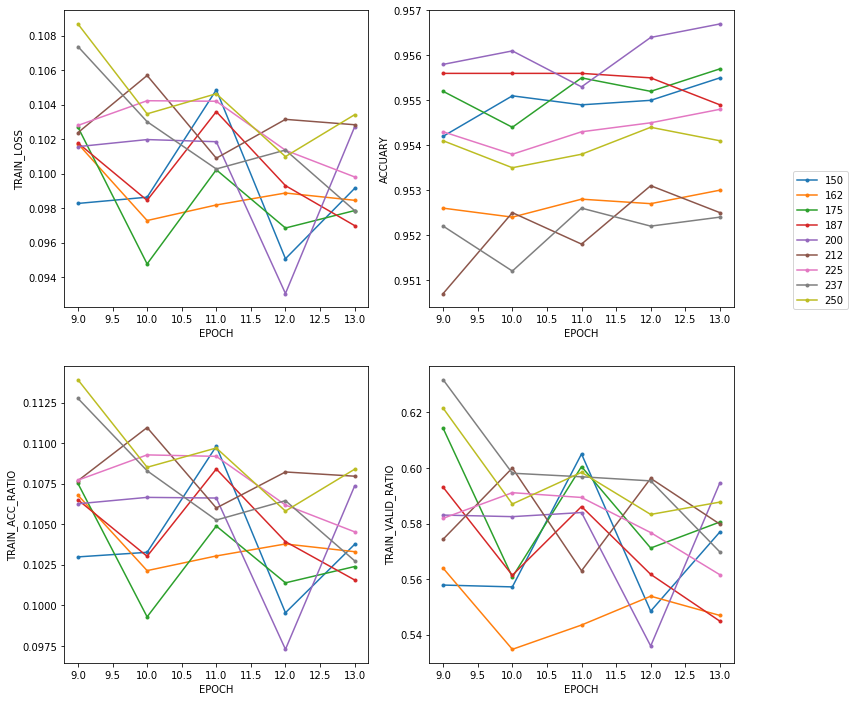

In [0]:
plot_df_groups(df_compare_slices_part2.head(14).tail(5),sw_groups,4,marker=".")

For further analysis we will chose models with beta parameter equal to 0.5, 0.625, 1.25, 2.0

In [0]:
select = [col for col in df_compare_slices.columns if col.endswith(('050','062','125','200'))]

In [0]:
df_compare_slices_final = df_compare_slices[select]
df_compare_slices_final.T.sort_index()

0         1   ...        16        17
accuracy_050            0.953300  0.954600  ...  0.956100  0.955900
accuracy_062            0.954600  0.952100  ...  0.957100  0.956300
accuracy_125            0.951200  0.954400  ...  0.954900       NaN
accuracy_200            0.952400  0.955100  ...       NaN       NaN
train_acc_ratio_050    0.125587  0.120742  ...  0.096848  0.101180
train_acc_ratio_062    0.125149  0.118301  ...  0.091880  0.096513
train_acc_ratio_125    0.125232  0.122783  ...  0.098871       NaN
train_acc_ratio_200    0.123940  0.121316  ...       NaN       NaN
train_loss_050         0.119722  0.115261  ...  0.092596  0.096718
train_loss_062         0.119467  0.112634  ...  0.087939  0.092295
train_loss_125         0.119121  0.117184  ...  0.094411       NaN
train_loss_200         0.118041  0.115869  ...       NaN       NaN
train_valid_ratio_050  0.744322  0.729641  ...  0.598510  0.623809
train_valid_ratio_062  0.751101  0.675136  ...  0.548692  0.581204
train_valid_ratio_125  0.698055  0.719448  ...  0.579989       NaN
train_valid_ratio_200  0.659237  0.655920  ...       NaN       NaN
valid_loss_050         0.160847  0.157969  ...  0.154711  0.155045
valid_loss_062         0.159056  0.166832  ...  0.160269  0.158800
valid_loss_125         0.170647  0.162881  ...  0.162782       NaN
valid_loss_200         0.179057  0.176650  ...       NaN       NaN

[20 rows x 18 columns]

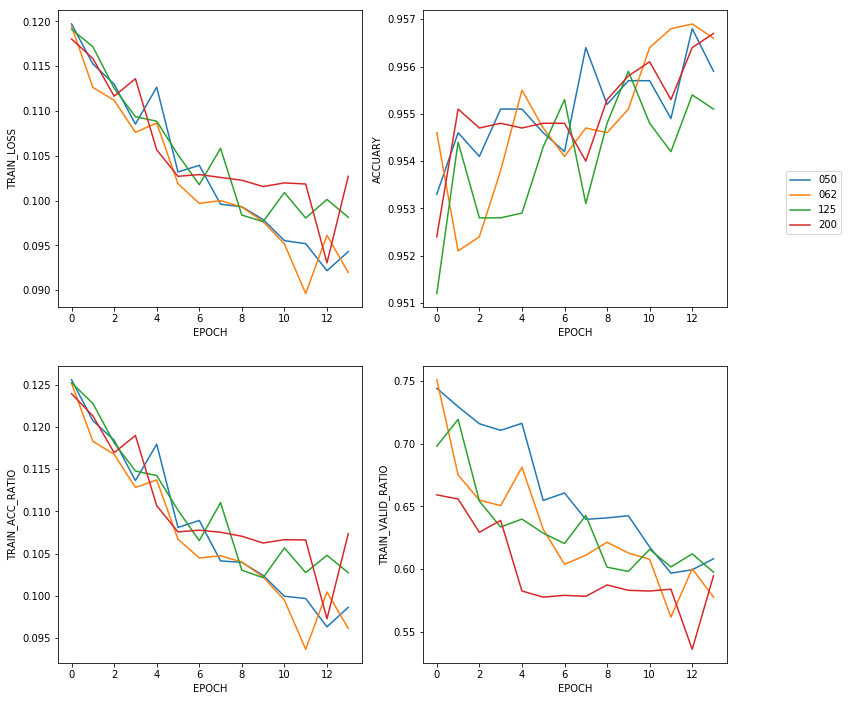

In [0]:
plot_df_groups(df_compare_slices_final.head(14),sw_groups,4,marker="")

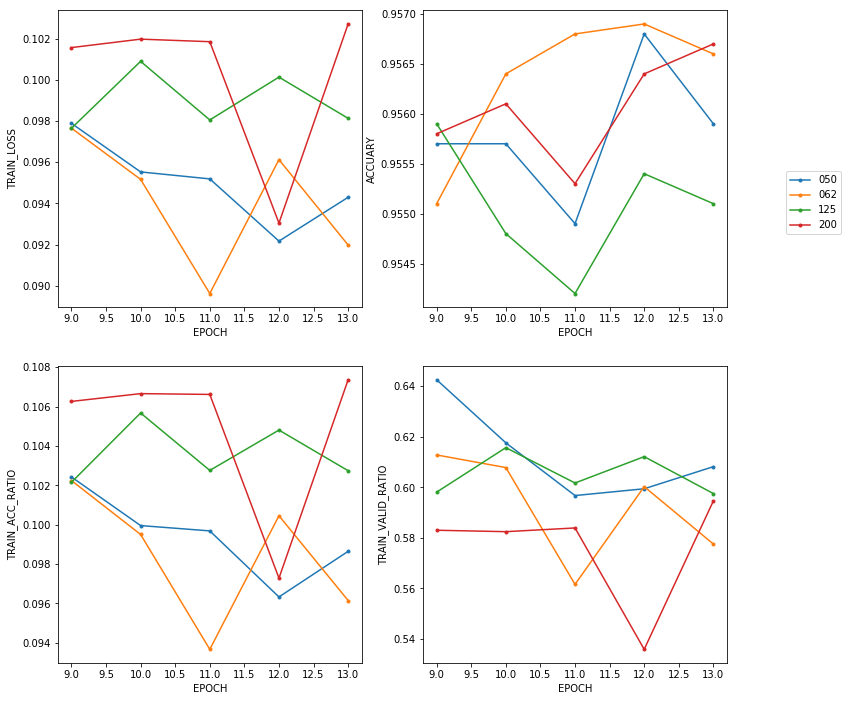

In [0]:
plot_df_groups(df_compare_slices_final.head(14).tail(5),sw_groups,4,marker=".")

In [0]:
select = [col for col in df_compare_slices.columns if col.endswith(('050','062'))]

In [0]:
df_compare_slices_final = df_compare_slices[select]
df_compare_slices_final.T.sort_index()

0         1   ...        16        17
accuracy_050            0.953300  0.954600  ...  0.956100  0.955900
accuracy_062            0.954600  0.952100  ...  0.957100  0.956300
train_acc_ratio_050    0.125587  0.120742  ...  0.096848  0.101180
train_acc_ratio_062    0.125149  0.118301  ...  0.091880  0.096513
train_loss_050         0.119722  0.115261  ...  0.092596  0.096718
train_loss_062         0.119467  0.112634  ...  0.087939  0.092295
train_valid_ratio_050  0.744322  0.729641  ...  0.598510  0.623809
train_valid_ratio_062  0.751101  0.675136  ...  0.548692  0.581204
valid_loss_050         0.160847  0.157969  ...  0.154711  0.155045
valid_loss_062         0.159056  0.166832  ...  0.160269  0.158800

[10 rows x 18 columns]

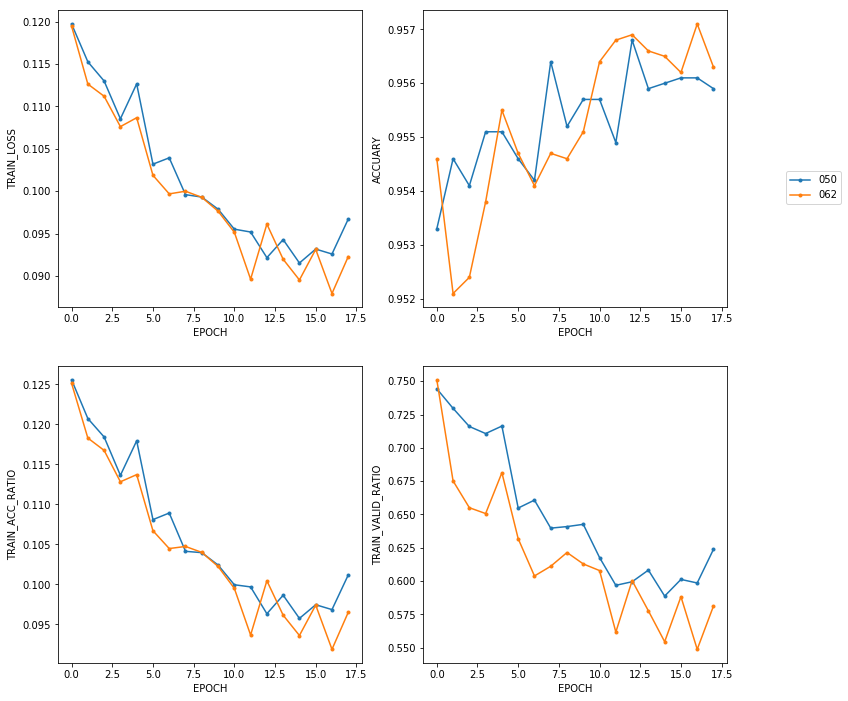

In [0]:
plot_df_groups(df_compare_slices_final,sw_groups,4,marker=".")

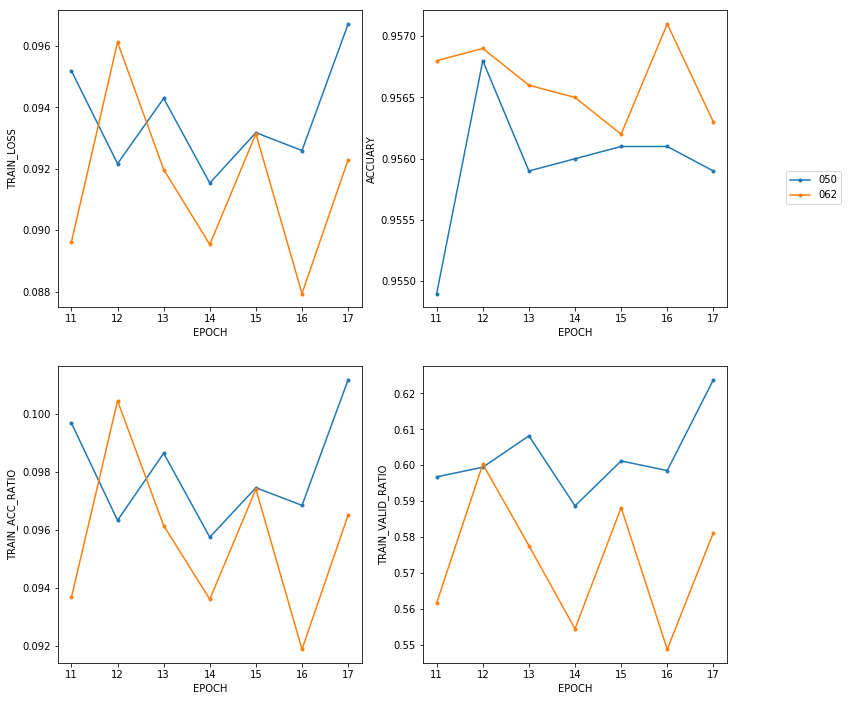

In [0]:
plot_df_groups(df_compare_slices_final.tail(7),sw_groups,4,marker=".")

As plots did not gave strict answer we will create dataframe to compare values in tabular form, we will also read .csv created from fitting relu model.

In [0]:
df_relu = pd.read_csv('df_wrn_concat_4_wider.csv',sep="|",index_col=[0])
df_relu["train_acc_ratio"] = df_relu['train_loss'] / df_relu['accuracy']


In [0]:
df_compare_sw_rl =  df_relu.copy()
i = 0 
for key in dfs.keys():
  if key in ['050','062','200']:
      i +=1
      if i ==3:
        df_compare_sw_rl = df_compare_sw_rl.join(dfs[key],lsuffix='_relu',rsuffix=f"_swish_{key}")
      else:
        df_compare_sw_rl = df_compare_sw_rl.join(dfs[key],lsuffix='',rsuffix=f"_swish_{key}")
      

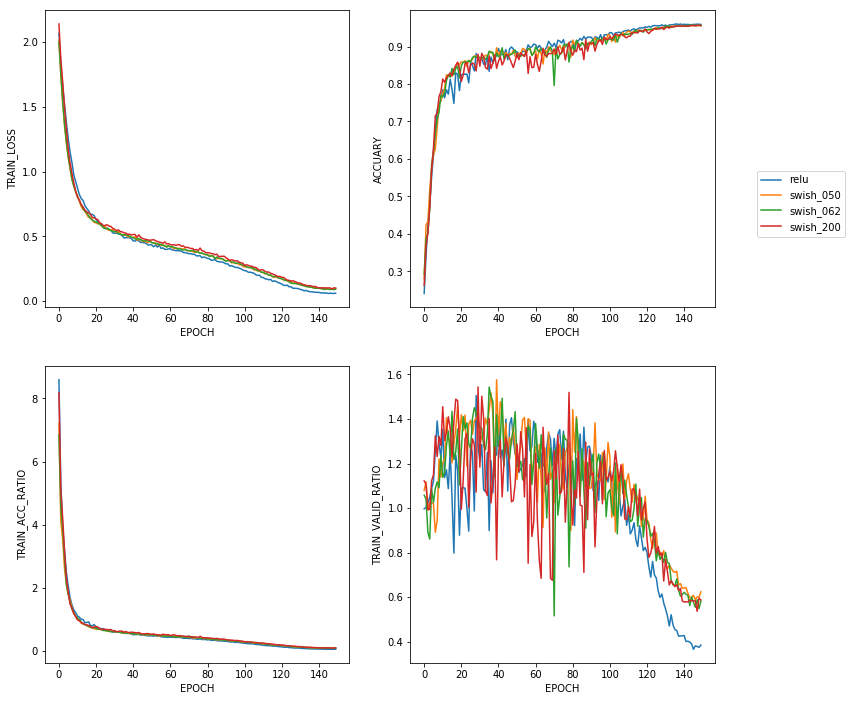

In [0]:
plot_df_groups(df_compare_sw_rl,sw_groups,4,marker="")

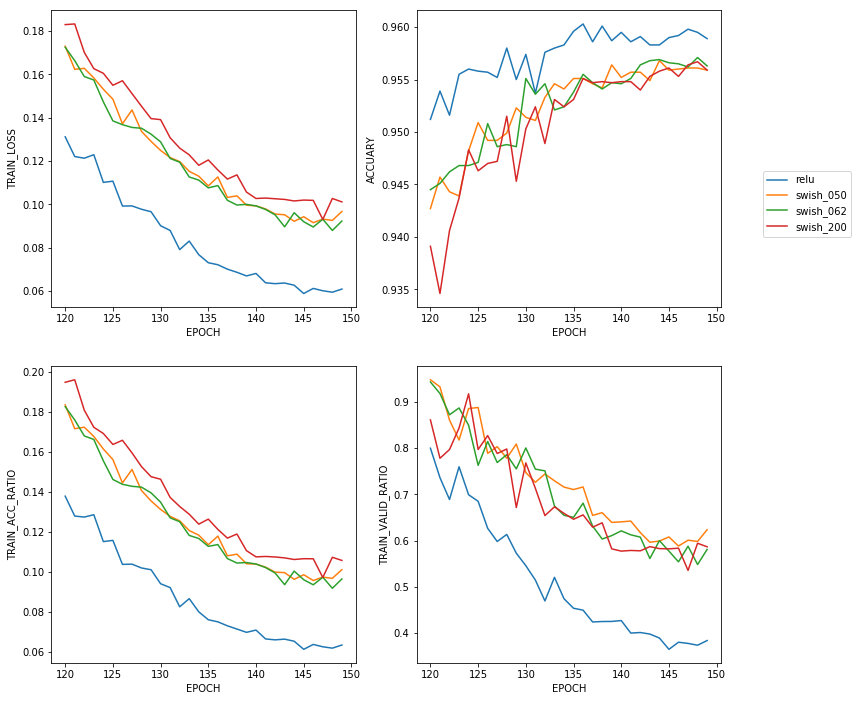

In [0]:
plot_df_groups(df_compare_sw_rl.tail(30),sw_groups,4,marker="")

In [0]:
df_compare_sw_rl_slices =  df_relu[df_relu['accuracy']>=.95].reset_index(drop=True)
i = 0 
for key in dfs.keys():
  if key in ['050','062','200']:
      i +=1
      temp = dfs[key][dfs[key]['accuracy']>=.95].reset_index(drop=True)
      if i ==3:
        df_compare_sw_rl_slices = df_compare_sw_rl_slices.join(temp,lsuffix='_relu',rsuffix=f"_swish_{key}")
      else:
        df_compare_sw_rl_slices = df_compare_sw_rl_slices.join(temp,lsuffix='',rsuffix=f"_swish_{key}")
      

In [0]:
df_compare_sw_rl_slices.T

0         1   ...        29        30
train_loss_relu              0.138722  0.131191  ...  0.059426  0.060880
valid_loss_relu              0.168471  0.163977  ...  0.158822  0.158438
accuracy_relu                 0.952700  0.951200  ...  0.959500  0.958900
train_valid_ratio_relu       0.823415  0.800055  ...  0.374170  0.384253
train_acc_ratio_relu         0.145609  0.137921  ...  0.061935  0.063490
train_loss_swish_050         0.148558  0.129075  ...       NaN       NaN
valid_loss_swish_050         0.167287  0.159534  ...       NaN       NaN
accuracy_swish_050            0.950900  0.952300  ...       NaN       NaN
train_valid_ratio_swish_050  0.888040  0.809076  ...       NaN       NaN
train_acc_ratio_swish_050    0.156229  0.135540  ...       NaN       NaN
train_loss_swish_062         0.136792  0.128863  ...       NaN       NaN
valid_loss_swish_062         0.167921  0.160949  ...       NaN       NaN
accuracy_swish_062            0.950800  0.955100  ...       NaN       NaN
train_valid_ratio_swish_062  0.814618  0.800645  ...       NaN       NaN
train_acc_ratio_swish_062    0.143870  0.134921  ...       NaN       NaN
train_loss_swish_200         0.145292  0.139116  ...       NaN       NaN
valid_loss_swish_200         0.181987  0.181073  ...       NaN       NaN
accuracy_swish_200            0.951500  0.950300  ...       NaN       NaN
train_valid_ratio_swish_200  0.798363  0.768288  ...       NaN       NaN
train_acc_ratio_swish_200    0.152697  0.146392  ...       NaN       NaN

[20 rows x 31 columns]

In [0]:
df_compare_sw_rl_slices.T.sort_index()

0         1   ...        29        30
accuracy_relu                 0.952700  0.951200  ...  0.959500  0.958900
accuracy_swish_050            0.950900  0.952300  ...       NaN       NaN
accuracy_swish_062            0.950800  0.955100  ...       NaN       NaN
accuracy_swish_200            0.951500  0.950300  ...       NaN       NaN
train_acc_ratio_relu         0.145609  0.137921  ...  0.061935  0.063490
train_acc_ratio_swish_050    0.156229  0.135540  ...       NaN       NaN
train_acc_ratio_swish_062    0.143870  0.134921  ...       NaN       NaN
train_acc_ratio_swish_200    0.152697  0.146392  ...       NaN       NaN
train_loss_relu              0.138722  0.131191  ...  0.059426  0.060880
train_loss_swish_050         0.148558  0.129075  ...       NaN       NaN
train_loss_swish_062         0.136792  0.128863  ...       NaN       NaN
train_loss_swish_200         0.145292  0.139116  ...       NaN       NaN
train_valid_ratio_relu       0.823415  0.800055  ...  0.374170  0.384253
train_valid_ratio_swish_050  0.888040  0.809076  ...       NaN       NaN
train_valid_ratio_swish_062  0.814618  0.800645  ...       NaN       NaN
train_valid_ratio_swish_200  0.798363  0.768288  ...       NaN       NaN
valid_loss_relu              0.168471  0.163977  ...  0.158822  0.158438
valid_loss_swish_050         0.167287  0.159534  ...       NaN       NaN
valid_loss_swish_062         0.167921  0.160949  ...       NaN       NaN
valid_loss_swish_200         0.181987  0.181073  ...       NaN       NaN

[20 rows x 31 columns]

All of above models are really comparable, in order to check which one would behave best probably all of the models should be trained to achieve global minimum.

As I don't have so much resources i will chose swish model with beta parameter equal to 0.5 as it had the smallest valid_loss and swish with beta equal to 2.0, as it had nice train_loss / accuracy ratio giving hope for best value of accuracy, and this is the metric we are looking for after all.  


#### Swish beta=2.0

In [25]:
arch = WideResNet_Concat(
    num_groups=4,
    N=2,
    num_classes=len(data.classes),
    k=7,
    drop_p=[.1,.2,.3,.4],
    drop_m=[1.5],
    drop_last_p =.65,
    activation= Swish,
    activation_parameters={"b":2.0})

learn_wrn_concat_4_sw200 = Learner(data, arch.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw200.to_fp16()
print()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


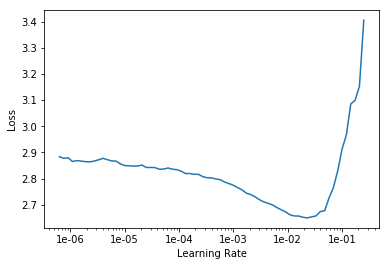

In [0]:
learn_wrn_concat_4_sw200.lr_find()
learn_wrn_concat_4_sw200.recorder.plot()

In [0]:
learn_wrn_concat_4_sw200.fit_one_cycle(300,max_lr=3e-03,wd=0.1,callbacks=[callbacks.SaveModelCallback(learn_wrn_concat_4_sw200, every='epoch', monitor='accuracy')])

In [0]:
df_wrn_concat_long_run_swish200 = get_metrics_save_to_disk(learn_wrn_concat_4_sw200,'df_wrn_concat_long_run_swish200')

Metrics saved to google disk under name:	df_wrn_concat_long_run_swish200.csv


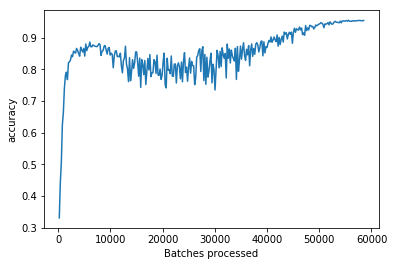

In [0]:
learn_wrn_concat_4_sw200.recorder.plot_metrics()

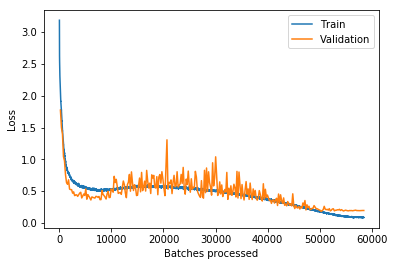

In [0]:
learn_wrn_concat_4_sw200.recorder.plot_losses()

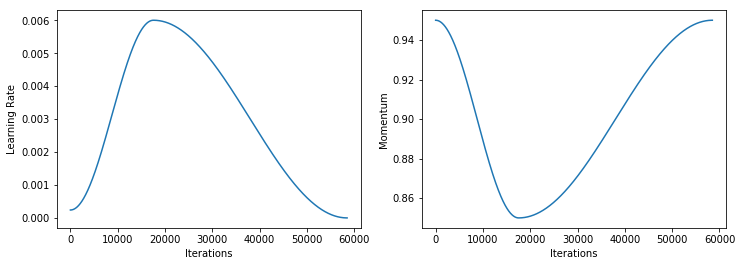

In [0]:
learn_wrn_concat_4_sw200.recorder.plot_lr(show_moms=True)

It is clearly noticeable that fitting jams somewhere around 0.45 train_loss error and won't decrease until max_lr is achieved.  
Only afterwards slowly starts to move, when momentums are more based on lr and lr is still high.  
In result we achieve much worser result than during testing phase.

#### Swish beta=0.5

In [0]:
arch = WideResNet_Concat(
    num_groups=4,
    N=2,
    num_classes=len(data.classes),
    k=7,
    drop_p=[.1,.2,.3,.4],
    drop_m=[1.5],
    drop_last_p =.65,
    activation= Swish,
    activation_parameters={"b":0.5})

learn_wrn_concat_4_sw050 = Learner(data, arch.cuda(), metrics=accuracy, loss_func = nn.CrossEntropyLoss())
learn_wrn_concat_4_sw050.to_fp16()
print()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


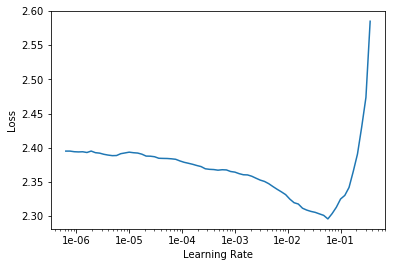

In [0]:
learn_wrn_concat_4_sw050.lr_find()
learn_wrn_concat_4_sw050.recorder.plot()

Let's do a long run again, but now for beta = 0.5.  
This time we will lower number of epochs and weight decay and increase learning rate.

In [0]:
learn_wrn_concat_4_sw050.fit_one_cycle(250,max_lr=1e-02,wd=0.03,callbacks=[callbacks.SaveModelCallback(learn_wrn_concat_4_sw050, every='epoch', monitor='accuracy')])

Buffered data was truncated after reaching the output size limit.

In [0]:
df_wrn_concat_long_run = get_metrics_save_to_disk(learn_wrn_concat_4_sw050,'df_wrn_concat_long_run')

Metrics saved to google disk under name:	df_wrn_concat_long_run.csv


In [0]:
df_wrn_concat_long_run.iloc[40:100,:]

train_loss  valid_loss accuracy train_valid_ratio
40  0.45937204    0.317251  0.8962           1.44798
41  0.45773616    0.323659  0.8944           1.41425
42  0.45383033    0.360211  0.8833            1.2599
43  0.44192874    0.375724  0.8765            1.1762
44  0.44439945    0.326041  0.8943           1.36302
45   0.4449872    0.307112  0.8988           1.44894
46   0.4455901    0.346215  0.8815           1.28703
47  0.43037263    0.368067  0.8789           1.16928
48  0.43626988    0.465627  0.8575          0.936952
49   0.4364723    0.315408  0.8966           1.38383
50   0.4446978    0.429837  0.8639           1.03457
51  0.42842776    0.334235  0.8868           1.28182
52   0.4411174    0.308408  0.8963           1.43031
53   0.4356961    0.320187  0.8967           1.36075
54  0.43309137    0.479365  0.8528          0.903469
55  0.43253344    0.419026  0.8636           1.03224
56  0.42562166    0.300810  0.8991           1.41492
57  0.42977893    0.349765  0.8815           1.22876
58  0.43289655    0.441159  0.8557           0.98127
59  0.42316875    0.321181  0.8972           1.31754
60  0.42372778    0.297446  0.9044           1.42456
61   0.4358161    0.329592  0.8894           1.32229
62  0.42684826    0.301158  0.8977           1.41736
63   0.4122714    0.370061  0.8789           1.11406
64  0.42638656    0.318814  0.8934           1.33742
65   0.4158788    0.400175  0.8727           1.03924
66  0.41359314    0.467316   0.845           0.88504
67   0.4200223    0.351008  0.8812           1.19662
68  0.42101023    0.371350  0.8781           1.13373
69  0.43196595    0.417302   0.863           1.03514
70  0.41703492    0.472666  0.8512          0.882304
71  0.41240272    0.373186  0.8735           1.10509
72  0.41106844    0.402765  0.8681           1.02062
73  0.40650603    0.346936  0.8804            1.1717
74  0.40390885    0.386759  0.8728           1.04434
75   0.4084411    0.332776   0.888           1.22738
76  0.40160596    0.381902  0.8715           1.05159
77  0.40100834    0.342403  0.8858           1.17116
78    0.397695    0.367644  0.8785           1.08174
79  0.40140688    0.318855  0.8937            1.2589
80  0.40256974    0.322847  0.8937           1.24693
81  0.38801634    0.401864  0.8741          0.965541
82  0.39488855    0.323935  0.8919           1.21904
83  0.39503998    0.633114  0.8101          0.623964
84  0.39081168    0.326338  0.8921           1.19757
85  0.38078004    0.352982  0.8837           1.07875
86  0.38988993    0.329102  0.8909           1.18471
87   0.3955087    0.278649  0.9057           1.41938
88  0.38493884    0.415014  0.8657          0.927533
89  0.39162332    0.300912  0.9008           1.30145
90  0.38487136    0.306577  0.8973           1.25538
91  0.38120395    0.366937  0.8817           1.03888
92  0.38274834    0.437885  0.8663          0.874085
93  0.37775496    0.282548  0.9032           1.33696
94  0.38012522    0.336249  0.8842           1.13049
95  0.37579912    0.347711  0.8848           1.08078
96  0.38444114    0.427473  0.8619          0.899334
97  0.36559302    0.308208  0.8971           1.18619
98   0.3802282    0.481951  0.8529          0.788935
99  0.37367424    0.348125  0.8907           1.07339

In [0]:
df_wrn_concat_long_run.iloc[100:150,:]

train_loss  valid_loss accuracy train_valid_ratio
100   0.3639218    0.325509  0.8901           1.11801
101   0.3592461    0.357676  0.8868           1.00439
102  0.36557043    0.310154  0.8953           1.17867
103  0.35379437    0.372699  0.8738          0.949276
104   0.3730525    0.314828  0.8974           1.18494
105   0.3618776    0.300890  0.9051           1.20269
106  0.35923362    0.277909  0.9091           1.29263
107  0.35656306    0.371318  0.8822          0.960263
108   0.3590845    0.295497  0.9038           1.21519
109  0.36379886    0.379379  0.8822          0.958932
110   0.3445759    0.344467  0.8891           1.00032
111  0.36108637    0.347480  0.8903           1.03916
112  0.34789985    0.317495  0.9027           1.09577
113  0.34983507    0.345401  0.8876           1.01284
114  0.34698156    0.560659  0.8434          0.618882
115  0.34659344    0.281019  0.9111           1.23335
116  0.34096268    0.444795  0.8719          0.766561
117  0.33282927    0.407233  0.8744          0.817294
118  0.34028846    0.332558  0.8936           1.02325
119   0.3427817    0.254665  0.9138           1.34601
120   0.3301262    0.359509  0.8882           0.91827
121  0.32601914    0.274835  0.9132           1.18624
122  0.33047163    0.300899  0.9039           1.09828
123   0.3311829    0.302401  0.9031           1.09518
124  0.33598214    0.358055  0.8837          0.938352
125  0.32732257    0.305230   0.903           1.07238
126  0.32476434    0.251878  0.9196           1.28937
127    0.326963    0.289270  0.9084            1.1303
128  0.31927362    0.279657  0.9103           1.14166
129   0.3214896    0.278180  0.9102           1.15569
130  0.31038135    0.266937  0.9144           1.16275
131  0.30547816    0.278335  0.9116           1.09752
132   0.3177509    0.280296  0.9116           1.13363
133  0.31389746    0.266754  0.9141           1.17673
134  0.30584392    0.337523  0.8914          0.906142
135  0.30702403    0.255547  0.9162           1.20144
136  0.30054483    0.319260  0.8979          0.941379
137  0.29621533    0.308715  0.9012          0.959509
138  0.30306107    0.297677  0.9049           1.01809
139   0.2830275    0.274985   0.912           1.02925
140  0.29734543    0.240677  0.9244           1.23546
141   0.3048889    0.344106  0.8914          0.886032
142  0.28116038    0.254429  0.9196           1.10506
143  0.29099143    0.300725  0.9058          0.967633
144  0.28426102    0.270393  0.9175           1.05129
145  0.27638143    0.244237  0.9215           1.13161
146  0.27276856    0.297296  0.9042          0.917497
147  0.27970156    0.597957  0.8369          0.467762
148  0.26867408    0.281368  0.9099          0.954885
149   0.2674211    0.308491  0.9076          0.866869

In [0]:
df_wrn_concat_long_run.iloc[150:200,:]

train_loss  valid_loss accuracy train_valid_ratio
150   0.26565567    0.296773  0.9096          0.895149
151   0.26513737    0.381456  0.8831          0.695067
152   0.25628936    0.255870   0.921           1.00164
153    0.2544451    0.249883  0.9176           1.01826
154     0.251464    0.247360  0.9221           1.01659
155   0.24797659    0.289412  0.9131          0.856829
156   0.25469628    0.280652  0.9113          0.907516
157   0.24393436    0.296195  0.9097          0.823561
158   0.24371018    0.313141  0.9053          0.778276
159   0.24157782    0.326883  0.9034          0.739034
160   0.23319274    0.222801  0.9302           1.04664
161   0.24316312    0.292176   0.911          0.832247
162   0.22897883    0.261213  0.9248          0.876598
163   0.23188052    0.365190  0.8958          0.634958
164   0.23036736    0.309295  0.9079          0.744814
165   0.22980504    0.289024  0.9136          0.795107
166   0.21612802    0.245585  0.9244          0.880055
167    0.2178769    0.240313  0.9278          0.906639
168    0.2228405    0.209794  0.9356           1.06219
169   0.20810053    0.293349  0.9154          0.709395
170   0.20387477    0.336182  0.9068          0.606442
171   0.20434923    0.201263  0.9381           1.01533
172   0.20099147    0.235732  0.9274          0.852625
173   0.20148578    0.216172  0.9355          0.932063
174   0.19055714    0.320199  0.9085          0.595121
175   0.19183244    0.219294  0.9323          0.874773
176   0.18726517    0.235967  0.9269          0.793607
177   0.18207192    0.239552  0.9298          0.760051
178   0.17867029    0.205886  0.9375          0.867814
179   0.17527853    0.314106  0.9113          0.558024
180   0.17727354    0.305148  0.9159          0.580943
181   0.17327607    0.194405  0.9412          0.891316
182    0.1784801    0.234541  0.9332          0.760976
183   0.16920179    0.215579   0.936          0.784872
184   0.16320227    0.224204  0.9334          0.727919
185   0.15609959    0.197520  0.9435          0.790299
186   0.15908521    0.206685  0.9407          0.769699
187   0.15191914    0.280033  0.9245          0.542505
188    0.1446205    0.278844  0.9272          0.518644
189   0.14600773    0.281555  0.9288          0.518575
190    0.1445032    0.238633  0.9371          0.605545
191   0.14288555    0.192751  0.9446          0.741295
192   0.13772263    0.219122  0.9374           0.62852
193   0.13641179    0.227937  0.9395          0.598463
194   0.12887865    0.217490  0.9421          0.592573
195    0.1276975    0.217908  0.9412          0.586016
196   0.12992163    0.202023  0.9465          0.643102
197   0.12511466    0.224897  0.9433          0.556321
198  0.124475636    0.185246  0.9496          0.671949
199  0.112904586    0.218284  0.9404          0.517237

In [0]:
df_wrn_concat_long_run.iloc[200:,:]

train_loss  valid_loss accuracy train_valid_ratio
200    0.1122359    0.216788   0.944          0.517723
201   0.10943543    0.223998  0.9412          0.488556
202   0.10772261    0.228437  0.9414          0.471564
203   0.10595538    0.208792  0.9452          0.507469
204  0.100539334    0.209479  0.9454           0.47995
205   0.10051235    0.192059  0.9483          0.523341
206   0.09550072    0.193544  0.9491          0.493432
207   0.10195329    0.228965   0.943          0.445279
208  0.095158204    0.224191  0.9443          0.424451
209   0.08645541    0.237893  0.9395          0.363422
210   0.08530669    0.239524   0.942           0.35615
211   0.08369455    0.195596  0.9492          0.427896
212   0.07969144    0.215545  0.9477          0.369721
213   0.07772053    0.217935  0.9471          0.356623
214   0.07170812    0.247290  0.9452          0.289976
215   0.07430489    0.225705   0.949          0.329213
216   0.07308966    0.202400  0.9515          0.361115
217   0.07147026    0.206237  0.9502          0.346544
218  0.068766415    0.228046  0.9474          0.301546
219  0.064084545    0.198866  0.9546          0.322251
220   0.06263129    0.196574  0.9543          0.318614
221   0.06278529    0.234451    0.95          0.267797
222  0.058965065    0.211634  0.9504          0.278619
223  0.059698977    0.213154  0.9524          0.280074
224  0.055328164    0.212739  0.9535          0.260076
225  0.052376963    0.201266  0.9545          0.260238
226  0.050423242    0.216072  0.9539          0.233364
227  0.053360514    0.199818  0.9559          0.267045
228   0.04915009    0.223199   0.953          0.220207
229  0.047163807    0.223238  0.9537          0.211272
230  0.046185166    0.219769  0.9545          0.210153
231  0.043588728    0.218462   0.953          0.199526
232  0.044392027    0.210316  0.9549          0.211073
233  0.044103418    0.204977  0.9558          0.215163
234  0.042398643    0.202856  0.9557          0.209008
235  0.042161595    0.221621  0.9528          0.190242
236  0.044682086    0.221186  0.9536          0.202011
237  0.040164985    0.212555  0.9562          0.188963
238  0.041773114    0.219940  0.9554          0.189929
239  0.042115297    0.212179  0.9559           0.19849
240  0.036208697    0.223481  0.9534          0.162021
241   0.03860129    0.219087  0.9549          0.176192
242   0.03986099    0.215669  0.9543          0.184825
243  0.041812625    0.218283  0.9541          0.191552
244  0.038301323    0.216596   0.955          0.176833
245  0.038369805    0.214710   0.955          0.178705
246   0.03680577    0.209437  0.9552          0.175737
247  0.039207205    0.217430   0.954          0.180321
248  0.038500253    0.211975  0.9547          0.181627
249  0.039995234    0.217817  0.9546          0.183618

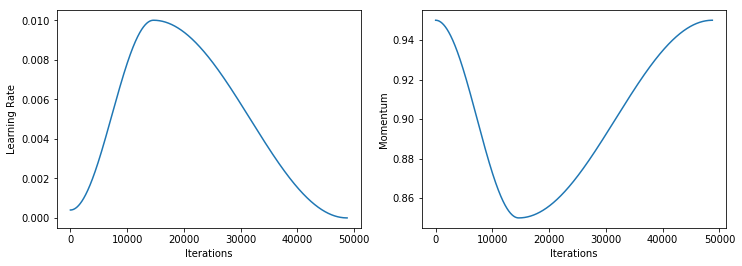

In [0]:
learn_wrn_concat_4_sw050.recorder.plot_lr(show_moms=True)

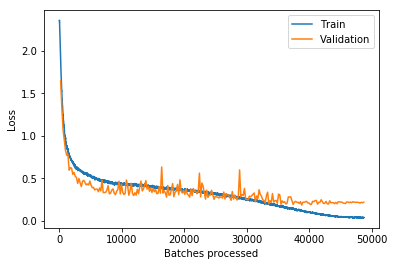

In [0]:
learn_wrn_concat_4_sw050.recorder.plot_losses()

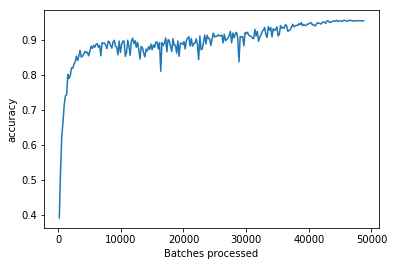

In [0]:
learn_wrn_concat_4_sw050.recorder.plot_metrics()

In [0]:
np.max(learn_wrn_concat_4_sw050.recorder.lrs)

0.01

In [0]:
learn_wrn_concat_4_sw050.recorder.lrs.index(0.01)

14625

In [0]:
learn_wrn_concat_4_sw050.recorder.lrs.index(0.01) / 195

75

In [0]:
df_wrn_concat_long_run.iloc[75,:]

train_loss           0.4084411
valid_loss            0.332776
accuracy                  0.888
train_valid_ratio      1.22738
Name: 75, dtype: object

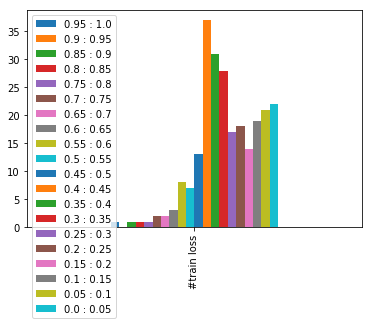

In [0]:
train_loss_records = {}
for x in np.linspace(1,0.05,20):
  array = f'{round(x-0.05,2)} : {round(x,2)}'
  train_loss_records[array] = df_wrn_concat_long_run[df_wrn_concat_long_run['train_loss'].between(x-0.05,x)].size / 4
ax = pd.DataFrame(train_loss_records, index=['#train loss']).plot.bar()
ax.legend(loc=2)
plt.show()

Although not as clearly as before fitting jams before achieving max_lr and slowly moves on afterwards.  
We will split fitting into smaller groups to receive restarts for one cycle policy.

Now that I think, it is such a waste I did not used save_best_model callback during testing - lesson to take for future.

In [0]:
learn_wrn_concat_4_sw050.fit_one_cycle(40,max_lr=1e-02,wd=0.06,callbacks=[callbacks.SaveModelCallback(learn_wrn_concat_4_sw050, every='epoch', monitor='accuracy')])

We decreased to 0.23 error in 40 epochs, during test it took 108 epochs to get to same state and during long run 160 epochs. 

In [0]:
swish_p101 = get_metrics_save_to_disk(learn_wrn_concat_4_sw050,'swish_p101')

Metrics saved to google disk under name:	swish_p101.csv


In [0]:
!cp ~/.fastai/data/cifar10/models/bestmodel_39.pth /content/
name1 = 'bestmodel_39'
name2 = 'swish_p101'
shutil.copy2(f'/content/{name1}.pth',f'/content/gdrive/My Drive/{name2}.pth')

'/content/gdrive/My Drive/swish_p101.pth'

In [0]:
learn_wrn_concat_4_sw050.load('/content/gdrive/My Drive/swish_p101')
print()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


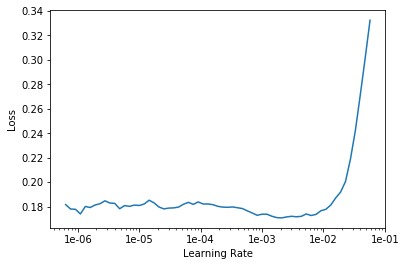

In [0]:
learn_wrn_concat_4_sw050.lr_find()
learn_wrn_concat_4_sw050.recorder.plot()

Loss starts to go up closing to 0.01 so we will stay with lr equal to 0.003 to kick off from local minimum if required.

Unfortunately google.colab stoped to co-working with me.  
After many tries of reconnection for few days with more than one account, time of iteration increased almost 6 times, for both loaded and from-scratch models.  
At this point I am stuck due to limit of resources as I couldn't even do what i would like to.  

Running 5 epochs took almost an hour, while connection time limit is 12 hours. This gives maximum of 60 epochs.  Let's remember that models are in fp16 precision, changing back to fp32 would double the time resulting in more than 20 minutes per epochs.  
Due to I will temporarily wait until some better days to end this project.  

In [0]:
learn_wrn_concat_4_sw050.fit_one_cycle(5,max_lr=3e-03,wd=0.01,callbacks=[callbacks.SaveModelCallback(learn_wrn_concat_4_sw050, every='epoch', monitor='accuracy')])

Nevertheless models created during test phase have beaten original kaggle competition best score of 0.9553 accuracy.  
In my opinion Concat Poolin over whole network is quite an easy trick to significantly leverage scores of any Convolutional Neural Network model.

#### Steps to take for tuning

    1. Freeze layers to 17, 43, 69, 95 and fit some more for each.
    2. Unfreeze, change to fp32 and fit again.
    3. Freeze layers to 17, 43, 69, 95 and fit.
    4. Set image size to 64, decrease batch_size to 64, change model to fp16 and fit.
    5. Repeat steps 1-3.
    6. Set image size to 128, decrease batch_size to 16, change model to fp16 and fit, repeat steps 1-3.



I hope that with all of these steps, our model would get close or even break 97% accuracy.  

Below is comparison of Swish 0.5 and 2.0 with models that scored best (num_groups=3), which makes me think that chosen Swish model would score at least same. 

In [0]:
paths = [
    'df_wrn_concat_3_wide_deep.csv',
    'df_wrn_concat_3_wider.csv',
    'df_wrn_concat_4_sw050.csv',
    'df_wrn_concat_4_sw200.csv'

]
suffixes = [
    '_3_wide_deep',
    '_3_wider',
    '_Swish_050',
    '_Swish_200'
]

os.chdir('/content/gdrive/My Drive/')

In [0]:
dfs = {key:pd.read_csv(path, sep="|",engine="c", index_col=[0]) for key,path in zip(suffixes,paths)}

In [0]:
dfs_slices = {key:dfs[key][dfs[key]['train_loss'] < 0.13 ].reset_index(drop=True) for key in dfs.keys()}

In [42]:
df_compare_slices = join_multi_dfs(dfs_slices)
df_compare_slices.head(20).T.sort_index()

0         1   ...        18        19
accuary__3_wide_deep            0.948200  0.952400  ...  0.962100  0.963400
accuary__3_wider                0.955700  0.955500  ...  0.961200  0.963400
accuary__Swish_050              0.952300  0.951400  ...  0.956100  0.956100
accuary__Swish_200              0.948900  0.953100  ...       NaN       NaN
train_loss__3_wide_deep         0.124126  0.120834  ...  0.054712  0.052096
train_loss__3_wider             0.120152  0.116273  ...  0.053819  0.050291
train_loss__Swish_050           0.129075  0.124903  ...  0.093177  0.092596
train_loss__Swish_200           0.125985  0.122849  ...       NaN       NaN
train_valid_ratio__3_wide_deep  0.609429  0.646048  ...  0.332402  0.311927
train_valid_ratio__3_wider      0.692468  0.676302  ...  0.308055  0.292772
train_valid_ratio__Swish_050    0.809076  0.747356  ...  0.601187  0.598510
train_valid_ratio__Swish_200    0.654462  0.673283  ...       NaN       NaN
valid_loss__3_wide_deep         0.203676  0.187035  ...  0.164596  0.167014
valid_loss__3_wider             0.173512  0.171924  ...  0.174706  0.171776
valid_loss__Swish_050           0.159534  0.167127  ...  0.154989  0.154711
valid_loss__Swish_200           0.192502  0.182463  ...       NaN       NaN

[16 rows x 20 columns]

# Summary 
Although I did not beat current STA, which was not my goal, I think that this notebook clearly shows that Concat Pooling might be a powerful technique to easily score better results with CNN models.  
We have beaten by far original Cifar-10 best submission for kaggle and with a high chance would score State of Art as of 2017 for a brief moment.  
Even as of now if we had a chance to max out accuracy with our model, we could place in top 10. (source: https://benchmarks.ai/cifar-10)